📄 Informe Ejecutivo
## Más allá de los números: desigualdades educativas en Colombia (2011–2023) y el camino hacia una educación equitativa en 2026

🎯 Propósito del Proyecto:

Este estudio busca analizar las brechas educativas en Colombia (2011–2023) en términos de cobertura, deserción, aprobación y repitencia, identificando patrones y factores explicativos que orienten políticas públicas en línea con el ODS 4 

🧮 Indicadores Analizados
- Cobertura total
- Tasa de aprobación
- Tasa de reprobación
- Tasa de repitencia
- Tasa de deserción

Estos indicadores se analizaron en series de tiempo (2011-2023) y se proyectaron hasta 2026.

🔍 Principales Hallazgos:

1. Persisten desigualdades marcadas entre regiones, siendo los municipios rurales y fronterizos los más vulnerables.
2. El índice de repitencia y deserción se concentra en territorios con menor inversión educativa y cobertura.
3. Algunos departamentos han mostrado avances sostenidos, mientras que otros presentan retrocesos estructurales.
4. El análisis de clústeres permitió agrupar municipios con trayectorias educativas similares, lo que aporta a políticas focalizadas.
5. Los modelos predictivos proyectan mejoras lentas sin intervenciones decisivas, por lo que se recomienda una acción política urgente para cerrar brechas antes de 2026.

🗺️ Productos Entregables

- Mapas interactivos por indicador, mostrando extremos y evolución.
- Panel de visualización con filtros por indicador, región y tiempo.
- Tablas de resumen comparativo entre departamentos.
- Clústeres de desempeño educativo.
- Predicciones hasta 2026.

📌 Recomendaciones

1. Fortalecer la recolección y estandarización de datos a nivel municipal.
2. Implementar intervenciones educativas diferenciadas según cluster de desempeño.
3. Priorizar inversión en departamentos rezagados con altas tasas de deserción.
4. Usar esta visualización como insumo para planes de desarrollo territorial y sectorial.

1. Importar librerías necesarias

In [79]:
# Manipulación de datos
import pandas as pd
import numpy as np
import unicodedata
import math

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import folium
from IPython.display import display, HTML
import ipywidgets as widgets

# Estadística y análisis matemático
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Machine Learning y modelos predictivos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from prophet import Prophet

# Geoespacial y mapas
import geopandas as gpd

# Manejo de advertencias
import warnings


2. Carga y limpieza básica del dataset

2.1 Carga de datos y copia de seguridad del df

In [80]:
df = pd.read_csv('MEN_ESTADISTICAS_EN_EDUCACION.csv')

# Crear una copia para trabajar sin modificar el original
df_work = df.copy()

2.2  Normalización de nombres de columnas

In [81]:
def normalizar_columna(col):
    col = col.lower()  # Convertir a minúsculas
    col = col.replace('año', 'anio')  # Reemplazar antes de eliminar tildes
    col = ''.join(
        c for c in unicodedata.normalize('NFD', col)
        if unicodedata.category(c) != 'Mn'
    )  # Eliminar tildes
    return col

df_work.columns = [normalizar_columna(col) for col in df_work.columns]


2.3 Verificación del resultado

In [82]:
print("Nombres de columnas normalizadas:")
print(df_work.columns.tolist())

Nombres de columnas normalizadas:
['anio', 'codigo_municipio', 'municipio', 'codigo_departamento', 'departamento', 'codigo_etc', 'etc', 'poblacion_5_16', 'tasa_matriculacion_5_16', 'cobertura_neta', 'cobertura_neta_transicion', 'cobertura_neta_primaria', 'cobertura_neta_secundaria', 'cobertura_neta_media', 'cobertura_bruta', 'cobertura_bruta_transicion', 'cobertura_bruta_primaria', 'cobertura_bruta_secundaria', 'cobertura_bruta_media', 'tamanio_promedio_de_grupo', 'sedes_conectadas_a_internet', 'desercion', 'desercion_transicion', 'desercion_primaria', 'desercion_secundaria', 'desercion_media', 'aprobacion', 'aprobacion_transicion', 'aprobacion_primaria', 'aprobacion_secundaria', 'aprobacion_media', 'reprobacion', 'reprobacion_transicion', 'reprobacion_primaria', 'reprobacion_secundaria', 'reprobacion_media', 'repitencia', 'repitencia_transicion', 'repitencia_primaria', 'repitencia_secundaria', 'repitencia_media']


In [83]:
# Número de filas y columnas
print("Dimensiones del dataset (filas, columnas):", df.shape)

Dimensiones del dataset (filas, columnas): (14585, 41)


3. EDA

3.1 Exploración inicial

In [45]:
filas, columnas = df_work.shape
print(f"El DataFrame tiene {filas} filas y {columnas} columnas.\n")

print("Primeras filas del dataset:")
print(df_work.head(), "\n")

print("Información general del dataset:")
print(df_work.info(), "\n")

print("Estadísticas descriptivas básicas:")
print(df_work.describe(include='all'), "\n")

El DataFrame tiene 14585 filas y 41 columnas.

Primeras filas del dataset:
   anio  codigo_municipio   municipio  codigo_departamento departamento  \
0  2023              5001    Medellín                    5    Antioquia   
1  2023              5002   Abejorral                    5    Antioquia   
2  2023              5004    Abriaquí                    5    Antioquia   
3  2023              5021  Alejandría                    5    Antioquia   
4  2023              5030       Amagá                    5    Antioquia   

   codigo_etc              etc poblacion_5_16  tasa_matriculacion_5_16  \
0      3759.0         Medellín         377562                    96.15   
1      3758.0  Antioquia (ETC)           3634                    74.38   
2      3758.0  Antioquia (ETC)            503                    62.62   
3      3758.0  Antioquia (ETC)            864                    81.37   
4      3758.0  Antioquia (ETC)           5060                    78.30   

   cobertura_neta  ...  repro

3.2 Análisis de valores nulos

In [84]:
total_posibles = df_work.size
total_no_nulos = df_work.notnull().sum().sum()
porcentaje_completo = (total_no_nulos / total_posibles) * 100

print(f"Total de valores posibles: {total_posibles}")
print(f"Total de valores no nulos: {total_no_nulos}")
print(f"Porcentaje de completitud del DataFrame: {porcentaje_completo:.2f}%\n")

porcentaje_nulos = df_work.isnull().mean().sort_values(ascending=False) * 100
print("Porcentaje de valores nulos por columna (orden descendente):")
print(porcentaje_nulos, "\n")


Total de valores posibles: 597985
Total de valores no nulos: 579275
Porcentaje de completitud del DataFrame: 96.87%

Porcentaje de valores nulos por columna (orden descendente):
tamanio_promedio_de_grupo      48.083648
sedes_conectadas_a_internet    46.739801
desercion_transicion            6.191292
desercion_media                 5.032568
desercion_secundaria            1.851217
desercion_primaria              1.659239
repitencia_transicion           1.090161
repitencia_secundaria           1.042167
repitencia_primaria             1.014741
reprobacion_media               0.994172
repitencia                      0.980459
desercion                       0.973603
repitencia_media                0.953034
cobertura_bruta_media           0.870758
tasa_matriculacion_5_16         0.788481
cobertura_neta                  0.761056
reprobacion_secundaria          0.726774
aprobacion_media                0.692492
cobertura_bruta_transicion      0.665067
reprobacion_primaria            0.665067
co

3.3 Revisar duplicados

In [85]:
for i in range(len(df_work.columns)):
    for j in range(i+1, len(df_work.columns)):
        if df_work.iloc[:, i].equals(df_work.iloc[:, j]):
            print(f"Las columnas '{df_work.columns[i]}' y '{df_work.columns[j]}' tienen los mismos datos.")

Las columnas 'aprobacion_transicion' y 'reprobacion_transicion' tienen los mismos datos.


3.4 Revisar columnas con muchos 0

In [86]:
zero_counts = (df_work == 0).sum()
# Filtrar solo las columnas que tienen al menos un cero
columns_with_zeros = zero_counts[zero_counts > 0]

# Mostrar el número de columnas con ceros
print(f"Número de columnas con al menos un valor en cero: {len(columns_with_zeros)}")

# Mostrar el nombre de las columnas y cuántos ceros tienen
print("\nColumnas con valores en cero y su cantidad:")
print(columns_with_zeros)

Número de columnas con al menos un valor en cero: 35

Columnas con valores en cero y su cantidad:
codigo_municipio                   3
codigo_departamento                3
codigo_etc                         3
tasa_matriculacion_5_16            5
cobertura_neta                     8
cobertura_neta_transicion          9
cobertura_neta_primaria            8
cobertura_neta_secundaria         26
cobertura_neta_media              50
cobertura_bruta                    8
cobertura_bruta_transicion         8
cobertura_bruta_primaria           8
cobertura_bruta_secundaria        26
cobertura_bruta_media             43
sedes_conectadas_a_internet      284
desercion                         55
desercion_transicion            1219
desercion_primaria               355
desercion_secundaria             195
desercion_media                  698
aprobacion                         3
aprobacion_transicion          10330
aprobacion_primaria                3
aprobacion_secundaria             14
aprobacion_med

4. Limpieza de datos

4.1 Eliminar columnas con más del 40% de valores nulos

In [87]:
columnas_a_eliminar = ['tamanio_promedio_de_grupo', 'sedes_conectadas_a_internet']
columnas_existentes = [col for col in columnas_a_eliminar if col in df_work.columns]
df_work.drop(columns=columnas_existentes, inplace=True)


4.2 Eliminar columnas con demasiados 0

In [88]:
columnas_a_eliminar = ['aprobacion_transicion', 'repitencia_transicion', 'reprobacion_transicion', 'cobertura_bruta_transicion', 'desercion_transicion', 'cobertura_neta_transicion']
columnas_existentes = [col for col in columnas_a_eliminar if col in df_work.columns]
df_work.drop(columns=columnas_existentes, inplace=True)

In [89]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14585 entries, 0 to 14584
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   anio                        14585 non-null  int64  
 1   codigo_municipio            14585 non-null  int64  
 2   municipio                   14585 non-null  object 
 3   codigo_departamento         14585 non-null  int64  
 4   departamento                14585 non-null  object 
 5   codigo_etc                  14585 non-null  float64
 6   etc                         14585 non-null  object 
 7   poblacion_5_16              14579 non-null  object 
 8   tasa_matriculacion_5_16     14470 non-null  float64
 9   cobertura_neta              14474 non-null  float64
 10  cobertura_neta_primaria     14494 non-null  float64
 11  cobertura_neta_secundaria   14491 non-null  float64
 12  cobertura_neta_media        14492 non-null  float64
 13  cobertura_bruta             145

Justificación para eliminar variables

Las variables **tamanio_promedio_de_grupo** y **sedes_conectadas_a_internet** presentan un alto porcentaje de datos faltantes, con un **48.08%** y **46.74%** de valores nulos, respectivamente. 

Este nivel de incompletitud limita la calidad y confiabilidad de los análisis, especialmente en modelos predictivos o análisis globales que requieren datos consistentes.

Por esta razón, se decidió eliminar estas variables del análisis principal para garantizar resultados más robustos y representativos. 

Sin embargo, se podrán considerar análisis focalizados en subconjuntos donde estas variables estén completas para explorar su posible impacto en la calidad educativa.

Las variables aprobacion_transicion, repitencia_transicion, reprobacion_transicion, cobertura_bruta_transicion, desercion_transicion, 'cobertura_neta_transicion, tasa_aprobacion_transicion también fueron retiradas por presentar exceso de ceros (0) en filas y columnas. 

4.3 Imputar valores numéricos faltantes

In [90]:
# Selecciona solo las columnas numéricas
columnas_numericas = df_work.select_dtypes(include='number').columns

# Recorre cada columna numérica
for col in columnas_numericas:
    # Calcular la mediana excluyendo ceros y nulos
    mediana = df_work.loc[(df_work[col] != 0) & (~df_work[col].isnull()), col].median()
    
    # Reemplazar ceros por la mediana
    df_work[col] = df_work[col].replace(0, mediana)
    
    # Reemplazar nulos por la mediana
    df_work[col] = df_work[col].fillna(mediana)

# Verificar imputaciones
print("✅ Imputación completa.")
print("Número de ceros por columna después de imputar:")
print((df_work[columnas_numericas] == 0).sum(), "\n")

print("Número de nulos por columna después de imputar:")
print(df_work[columnas_numericas].isnull().sum())

✅ Imputación completa.
Número de ceros por columna después de imputar:
anio                          0
codigo_municipio              0
codigo_departamento           0
codigo_etc                    0
tasa_matriculacion_5_16       0
cobertura_neta                0
cobertura_neta_primaria       0
cobertura_neta_secundaria     0
cobertura_neta_media          0
cobertura_bruta               0
cobertura_bruta_primaria      0
cobertura_bruta_secundaria    0
cobertura_bruta_media         0
desercion                     0
desercion_primaria            0
desercion_secundaria          0
desercion_media               0
aprobacion                    0
aprobacion_primaria           0
aprobacion_secundaria         0
aprobacion_media              0
reprobacion                   0
reprobacion_primaria          0
reprobacion_secundaria        0
reprobacion_media             0
repitencia                    0
repitencia_primaria           0
repitencia_secundaria         0
repitencia_media              0
d

4.4 Imputar valores en columnas categóricas (texto)

In [91]:
columnas_categoricas = df_work.select_dtypes(include=['object']).columns
nulos_categoricos = df_work[columnas_categoricas].isnull().sum()
print("Valores nulos en columnas categóricas:")
print(nulos_categoricos[nulos_categoricos > 0], "\n")

# Caso específico: convertir columna 'POBLACIÓN_5_16' a numérico e imputar
if 'poblacion_5_16' in df_work.columns:
    df_work['poblacion_5_16'] = pd.to_numeric(df_work['poblacion_5_16'], errors='coerce')
    mediana_poblacion = df_work['poblacion_5_16'].median()
    df_work['poblacion_5_16'] = df_work['poblacion_5_16'].fillna(mediana_poblacion)
    print(f"Valores nulos en 'poblacion_5_16' después de imputar: {df_work['poblacion_5_16'].isnull().sum()}")
    print(f"Tipo de dato actual en 'poblacion_5_16': {df_work['poblacion_5_16'].dtype}\n")

Valores nulos en columnas categóricas:
poblacion_5_16    6
dtype: int64 

Valores nulos en 'poblacion_5_16' después de imputar: 0
Tipo de dato actual en 'poblacion_5_16': float64



In [54]:
#Estado final de valores nulos en DataFrame trabajado
print("Resumen final de valores nulos en DataFrame trabajado:")
print(df_work.isnull().sum())

Resumen final de valores nulos en DataFrame trabajado:
anio                          0
codigo_municipio              0
municipio                     0
codigo_departamento           0
departamento                  0
codigo_etc                    0
etc                           0
poblacion_5_16                0
tasa_matriculacion_5_16       0
cobertura_neta                0
cobertura_neta_primaria       0
cobertura_neta_secundaria     0
cobertura_neta_media          0
cobertura_bruta               0
cobertura_bruta_primaria      0
cobertura_bruta_secundaria    0
cobertura_bruta_media         0
desercion                     0
desercion_primaria            0
desercion_secundaria          0
desercion_media               0
aprobacion                    0
aprobacion_primaria           0
aprobacion_secundaria         0
aprobacion_media              0
reprobacion                   0
reprobacion_primaria          0
reprobacion_secundaria        0
reprobacion_media             0
repitencia       

In [92]:
#Verificar columnas después de eliminar la columna repetida
print(df_work.columns)

Index(['anio', 'codigo_municipio', 'municipio', 'codigo_departamento',
       'departamento', 'codigo_etc', 'etc', 'poblacion_5_16',
       'tasa_matriculacion_5_16', 'cobertura_neta', 'cobertura_neta_primaria',
       'cobertura_neta_secundaria', 'cobertura_neta_media', 'cobertura_bruta',
       'cobertura_bruta_primaria', 'cobertura_bruta_secundaria',
       'cobertura_bruta_media', 'desercion', 'desercion_primaria',
       'desercion_secundaria', 'desercion_media', 'aprobacion',
       'aprobacion_primaria', 'aprobacion_secundaria', 'aprobacion_media',
       'reprobacion', 'reprobacion_primaria', 'reprobacion_secundaria',
       'reprobacion_media', 'repitencia', 'repitencia_primaria',
       'repitencia_secundaria', 'repitencia_media'],
      dtype='object')


4.5 Eliminar filas con codigo 0

In [93]:
df_work = df_work[df_work['municipio'] != 'NACIONAL']
'NACIONAL' in df_work['municipio'].values  

False

In [94]:
# Número de filas y columnas
print("Dimensiones del dataset (filas, columnas):", df_work.shape)

Dimensiones del dataset (filas, columnas): (14582, 33)


In [95]:
print(df_work.dtypes)

anio                            int64
codigo_municipio                int64
municipio                      object
codigo_departamento             int64
departamento                   object
codigo_etc                    float64
etc                            object
poblacion_5_16                float64
tasa_matriculacion_5_16       float64
cobertura_neta                float64
cobertura_neta_primaria       float64
cobertura_neta_secundaria     float64
cobertura_neta_media          float64
cobertura_bruta               float64
cobertura_bruta_primaria      float64
cobertura_bruta_secundaria    float64
cobertura_bruta_media         float64
desercion                     float64
desercion_primaria            float64
desercion_secundaria          float64
desercion_media               float64
aprobacion                    float64
aprobacion_primaria           float64
aprobacion_secundaria         float64
aprobacion_media              float64
reprobacion                   float64
reprobacion_

In [96]:
# Corregir los nombres de los departamentos
# Diccionario con las correcciones necesarias
correcciones = {
    'Bogotá D.C.': 'Bogotá, D.C.',
    'Archipiélago de San Andrés. Providencia y Santa Catalina': 'Archipiélago de San Andrés, Providencia y Santa Catalina'
}

# Aplicar reemplazo exacto
df_work['departamento'] = df_work['departamento'].replace(correcciones)

# Verificamos que solo queden las versiones correctas
print(df_work['departamento'].unique())

['Antioquia' 'Atlántico' 'Bogotá, D.C.' 'Bolívar' 'Boyacá' 'Caldas'
 'Caquetá' 'Cauca' 'Cesar' 'Córdoba' 'Cundinamarca' 'Chocó' 'Huila'
 'La Guajira' 'Magdalena' 'Meta' 'Nariño' 'Norte de Santander' 'Quindio'
 'Risaralda' 'Santander' 'Sucre' 'Tolima' 'Valle del Cauca' 'Arauca'
 'Casanare' 'Putumayo'
 'Archipiélago de San Andrés, Providencia y Santa Catalina' 'Amazonas'
 'Guainía' 'Guaviare' 'Vaupés' 'Vichada']


5. EDA visual

Variables encontradas en el DataFrame:
['tasa_matriculacion_5_16', 'cobertura_neta', 'cobertura_neta_primaria', 'cobertura_neta_secundaria', 'cobertura_neta_media', 'cobertura_bruta', 'cobertura_bruta_primaria', 'cobertura_bruta_secundaria', 'cobertura_bruta_media', 'desercion', 'desercion_primaria', 'desercion_secundaria', 'desercion_media', 'aprobacion', 'aprobacion_primaria', 'aprobacion_secundaria', 'aprobacion_media', 'reprobacion', 'reprobacion_primaria', 'reprobacion_secundaria', 'reprobacion_media', 'repitencia', 'repitencia_primaria', 'repitencia_secundaria', 'repitencia_media']


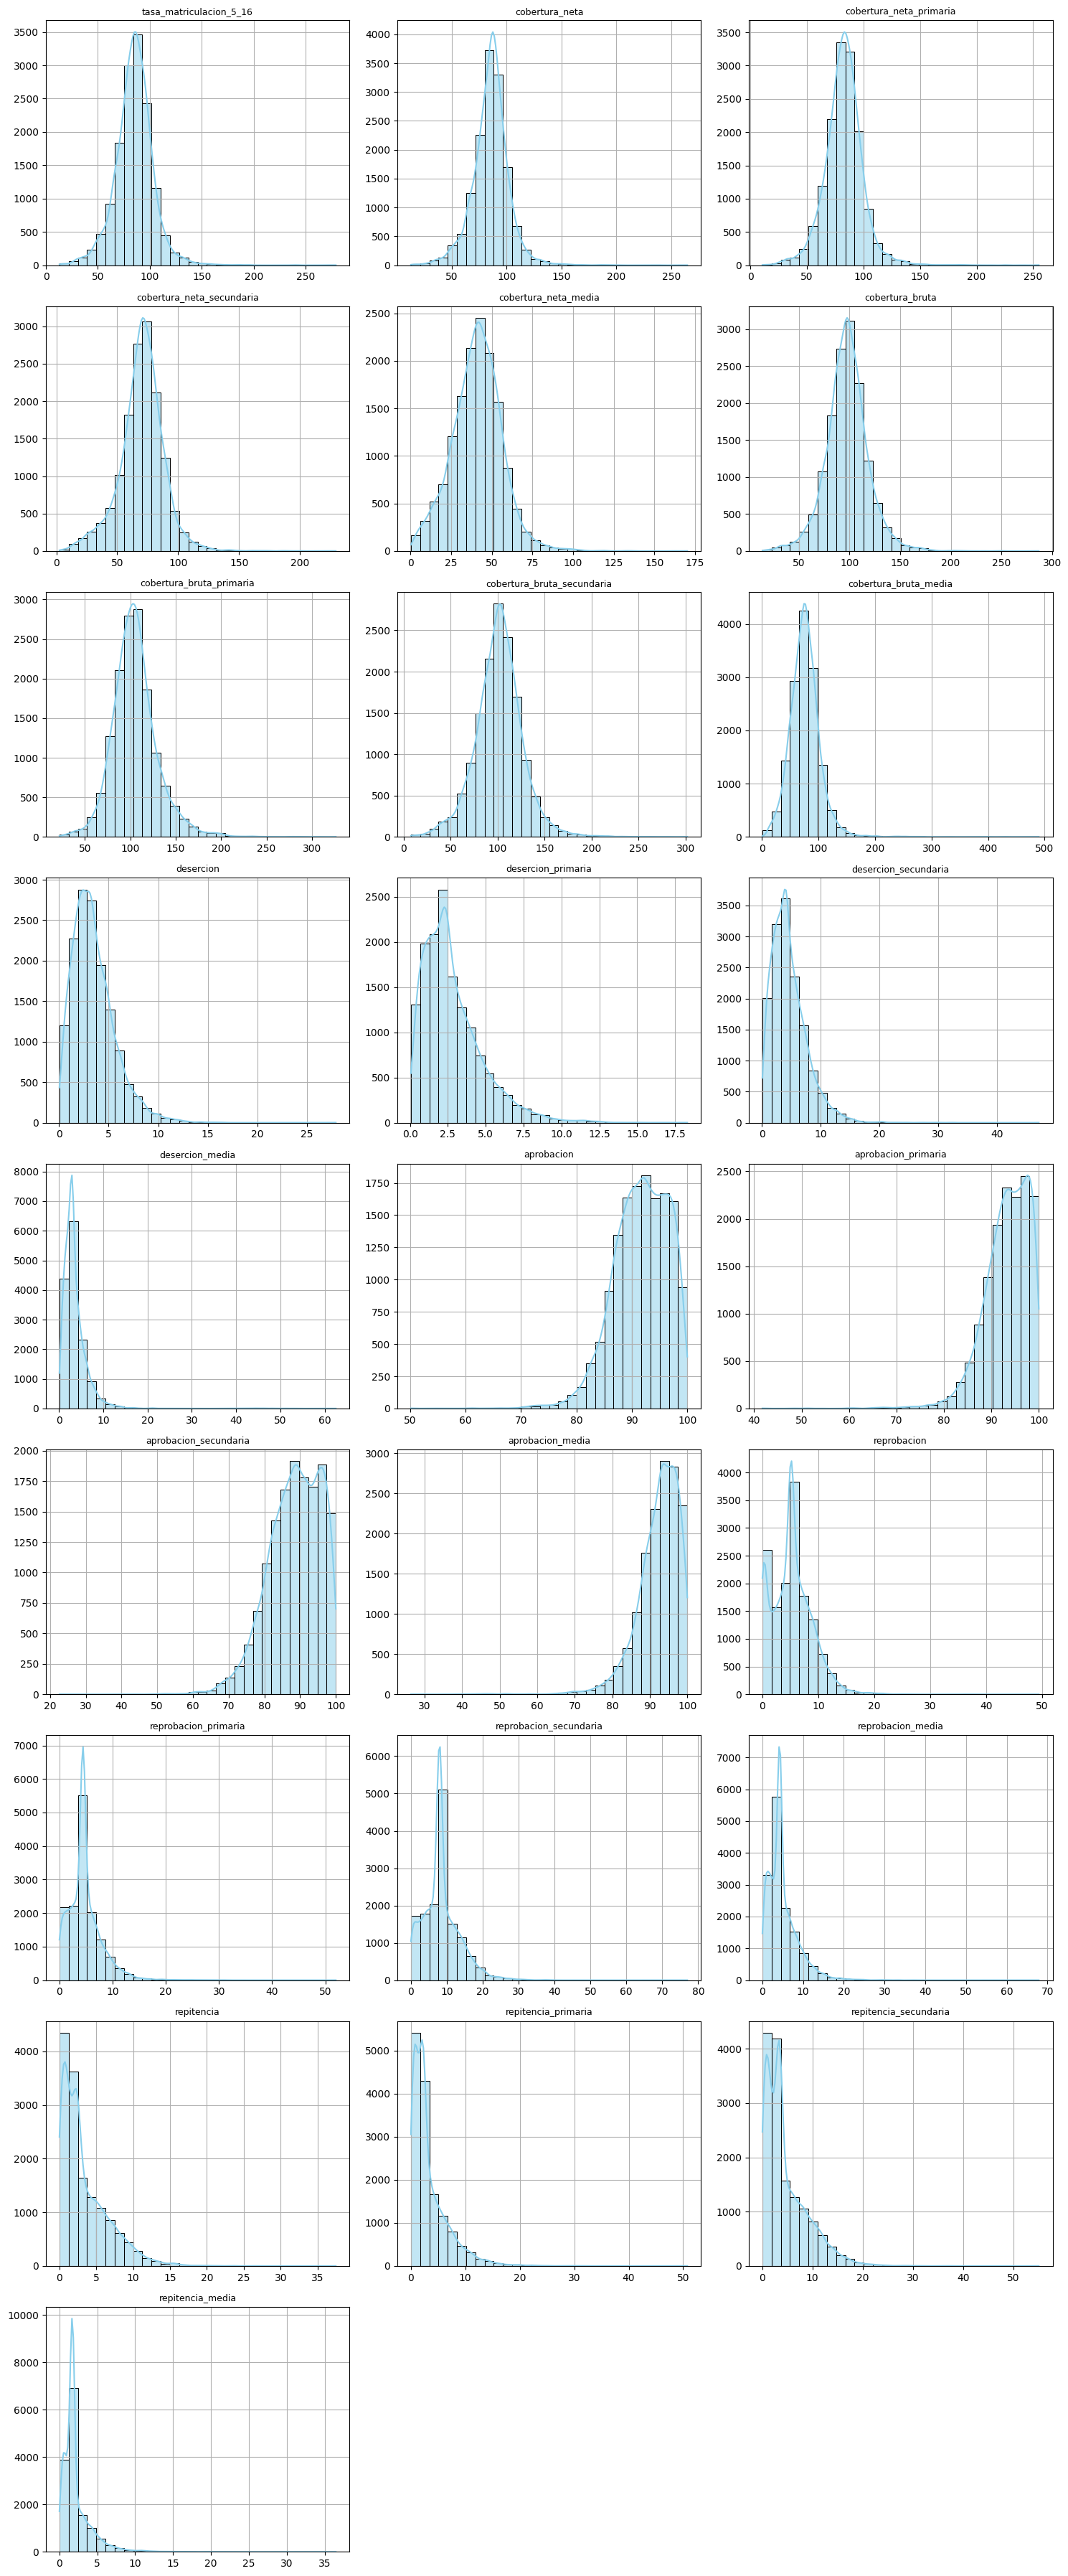

In [97]:
# Lista de variables a graficar
variables_objetivo = [ 
    'tasa_matriculacion_5_16', 
    'cobertura_neta', 'cobertura_neta_transicion', 'cobertura_neta_primaria',  
    'cobertura_neta_secundaria', 'cobertura_neta_media', 
    'cobertura_bruta', 'cobertura_bruta_transicion', 'cobertura_bruta_primaria',  
    'cobertura_bruta_secundaria', 'cobertura_bruta_media', 
    'desercion', 'desercion_transicion', 'desercion_primaria',  
    'desercion_secundaria', 'desercion_media', 
    'aprobacion', 'aprobacion_transicion', 'aprobacion_primaria',  
    'aprobacion_secundaria', 'aprobacion_media', 
    'reprobacion', 'reprobacion_primaria', 
    'reprobacion_secundaria', 'reprobacion_media',
    'repitencia', 'repitencia_transicion', 'repitencia_primaria', 
    'repitencia_secundaria', 'repitencia_media'
]

# Diagnóstico: columnas encontradas y no encontradas
variables_existentes = [var for var in variables_objetivo if var in df_work.columns]
variables_faltantes = [var for var in variables_objetivo if var not in df_work.columns]

print("Variables encontradas en el DataFrame:")
print(variables_existentes)

# Si hay columnas válidas, generar los histogramas
if variables_existentes:
    n = len(variables_existentes)
    cols = 3
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols*5, rows*4))

    for i, var in enumerate(variables_existentes, 1):
        plt.subplot(rows, cols, i)
        sns.histplot(df_work[var].dropna(), kde=True, bins=30, color='skyblue')
        plt.title(f'{var}', fontsize=9)
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)

    plt.tight_layout()
    plt.show()



Analizando las variables educativas recopiladas se identifican patrones que reflejan tanto fortalezas como debilidades del sistema escolar. Por un lado, las tasas de cobertura y matriculación brindan un panorama sobre el acceso a la educación formal, destacando cuántos estudiantes logran ingresar y permanecer en el sistema. No obstante, al observar indicadores como la deserción, reprobación y repitencia, emergen señales de alerta relacionadas con la calidad de la enseñanza, las condiciones socioeconómicas del estudiantado y los factores psicosociales que afectan la permanencia escolar.

En niveles como secundaria y media, usualmente se registran mayores tasas de deserción y repitencia, lo que puede estar asociado a factores como el ingreso temprano al mercado laboral, el cuidado de familiares o la falta de motivación académica. Estos elementos requieren una intervención integral, que combine estrategias pedagógicas con acompañamiento psicosocial, fortalecimiento familiar y políticas de inclusión educativa.

Por lo anterior, el conjunto de indicadores del presente estudio,  resulta esencial para formular diagnósticos precisos que orienten programas de mejora educativa, prevención del abandono escolar y promoción del bienestar estudiantil.
 

In [98]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14582 entries, 0 to 14584
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   anio                        14582 non-null  int64  
 1   codigo_municipio            14582 non-null  int64  
 2   municipio                   14582 non-null  object 
 3   codigo_departamento         14582 non-null  int64  
 4   departamento                14582 non-null  object 
 5   codigo_etc                  14582 non-null  float64
 6   etc                         14582 non-null  object 
 7   poblacion_5_16              14582 non-null  float64
 8   tasa_matriculacion_5_16     14582 non-null  float64
 9   cobertura_neta              14582 non-null  float64
 10  cobertura_neta_primaria     14582 non-null  float64
 11  cobertura_neta_secundaria   14582 non-null  float64
 12  cobertura_neta_media        14582 non-null  float64
 13  cobertura_bruta             14582 no

In [99]:
df_work.to_csv('df_work_limpio.csv', index=False)


In [100]:
# Cargar GeoJSON con geopandas
gdf = gpd.read_file("colombia_departamentos.geojson.json")

# Normalizar nombres en df_work y gdf
df_work["departamento"] = df_work["departamento"].str.lower().str.replace(r"[^a-záéíóúñ ]", "", regex=True).str.strip()
gdf["name"] = gdf["name"].str.lower().str.replace(r"[^a-záéíóúñ ]", "", regex=True).str.strip()

# Filtrar departamentos válidos
departamentos_validos = [d for d in df_work["departamento"].unique().tolist() if "san andrés" not in d and "nacional" not in d]
gdf = gdf[gdf["name"].isin(departamentos_validos)]

# Reproyectar a CRS métrico para cálculo correcto de centroides
gdf_proj = gdf.to_crs(epsg=3857)
centroides_wgs84 = gpd.GeoSeries(gdf_proj.centroid, crs="EPSG:3857").to_crs(epsg=4326)

# Agregar centroides reproyectados a GeoDataFrame original
gdf = gdf.assign(centroid=centroides_wgs84)

# Indicadores
indicadores = ["desercion", "repitencia", "reprobacion", "aprobacion", "cobertura_neta"]

def color_por_valor(valor, minimo, maximo):
    if maximo == minimo:
        return "rgb(128,128,128)"
    proporcion = (valor - minimo) / (maximo - minimo)
    return f"rgb({int(255 * proporcion)},{int(255 * (1 - proporcion))},0)"

def crear_mapa(indicador):
    agr = df_work.groupby("departamento")[[indicador]].mean().reset_index()
    min_val_color, max_val_color = agr[indicador].min(), agr[indicador].max()
    min_val, max_val = df_work[indicador].min(), df_work[indicador].max()

    min_deptos = ", ".join(sorted(df_work[df_work[indicador] == min_val]["departamento"].str.capitalize().unique()))
    max_deptos = ", ".join(sorted(df_work[df_work[indicador] == max_val]["departamento"].str.capitalize().unique()))

    m = folium.Map(location=[4.6, -74.1], zoom_start=6)

    def style_function(feature):
        dept = feature["properties"]["name"]
        val = agr.loc[agr["departamento"] == dept, indicador]
        color = color_por_valor(val.values[0], min_val_color, max_val_color) if not val.empty else "gray"
        return {"fillColor": color, "color": "black", "weight": 1, "fillOpacity": 0.7}

    folium.GeoJson(gdf[["geometry", "name"]].__geo_interface__, style_function=style_function).add_to(m)

    # Agregar marcadores para valores extremos
    for _, row in df_work[df_work[indicador].isin([min_val, max_val])].iterrows():
        dept = row["departamento"]
        centroid = gdf.loc[gdf["name"] == dept, "centroid"]
        if not centroid.empty:
            lat, lon = centroid.values[0].y, centroid.values[0].x
            color, tipo = ("green", "Mínimo") if row[indicador] == min_val else ("red", "Máximo")
            folium.Marker(
                location=[lat, lon], popup=f"<b>{dept.capitalize()}</b><br>{indicador.capitalize()} {tipo}: {row[indicador]:.2f}",
                icon=folium.Icon(color=color)
            ).add_to(m)

    return m._repr_html_(), (indicador, min_deptos, min_val, max_deptos, max_val)

maps_html, tabla_datos = [], []

for ind in indicadores:
    mapa_html, resumen = crear_mapa(ind)
    maps_html.append(widgets.HTML(value=mapa_html))
    tabla_datos.append(resumen)

grid = widgets.GridBox(maps_html, layout=widgets.Layout(grid_template_columns="50% 50%", grid_template_rows="auto auto", grid_gap="10px"))
display(grid)

html_tabla = """
<p style="margin-top: 20px;"><strong>Colores:</strong>
<span style="color:green;">● Verde = Departamento con valor más bajo</span>,
<span style="color:red;">● Rojo = Departamento con valor más alto</span></p>
<table style="border-collapse: collapse; width: 100%; margin-top: 10px;">
<thead><tr style="background-color: #f2f2f2;">
<th style="border: 1px solid #ddd; padding: 8px;">Indicador</th>
<th style="border: 1px solid #ddd; padding: 8px;">Departamento (Min)</th>
<th style="border: 1px solid #ddd; padding: 8px;">Valor Mínimo</th>
<th style="border: 1px solid #ddd; padding: 8px;">Departamento (Max)</th>
<th style="border: 1px solid #ddd; padding: 8px;">Valor Máximo</th>
</tr></thead><tbody>
"""

for ind, dept_min, val_min, dept_max, val_max in tabla_datos:
    html_tabla += f"""
    <tr>
    <td style="border: 1px solid #ddd; padding: 8px;">{ind.capitalize()}</td>
    <td style="border: 1px solid #ddd; padding: 8px; color: green;"><strong>{dept_min}</strong> ●</td>
    <td style="border: 1px solid #ddd; padding: 8px; color: green;">{val_min:.2f}</td>
    <td style="border: 1px solid #ddd; padding: 8px; color: red;"><strong>{dept_max}</strong> ●</td>
    <td style="border: 1px solid #ddd; padding: 8px; color: red;">{val_max:.2f}</td>
    </tr>
    """

html_tabla += "</tbody></table>"
display(HTML(html_tabla))

GridBox(children=(HTML(value='<div style="width:100%;"><div style="position:relative;width:100%;height:0;paddi…

Indicador,Departamento (Min),Valor Mínimo,Departamento (Max),Valor Máximo
Desercion,Nariño ●,0.05,Guainía ●,27.90
Repitencia,"Cauca, Cesar, Chocó, Meta, Nariño, Sucre, Tolima, Valle del cauca ●",0.01,Bolívar ●,37.47
Reprobacion,"Antioquia, Arauca, Archipiélago de san andrés providencia y santa catalina, Bolívar, Boyacá, Caquetá, Cauca, Cundinamarca, Córdoba, Guaviare, La guajira, Magdalena, Meta, Nariño, Putumayo, Valle del cauca ●",0.01,Bolívar ●,49.39
Aprobacion,Bolívar ●,50.14,"Amazonas, Bolívar, Casanare, Cundinamarca, Guainía, Nariño, Santander, Vaupés ●",100.00
Cobertura_neta,Amazonas ●,13.02,Atlántico ●,264.54


6.  Análisis por objetivos

6.1 Análisis Temporal (Objetivo Específico 1): Describir la evolución temporal de la cobertura, deserción, aprobación y repitencia en la educación preescolar, básica y media en los municipios de Colombia entre 2011 y 2023.

6.1.1 Estadísticas básicas anuales

In [101]:
# Lista de indicadores clave con nombres ya normalizados (sin tildes ni mayúsculas)
indicadores_clave = [ 
    'cobertura_neta', 'cobertura_neta_primaria', 
    'cobertura_neta_secundaria', 'cobertura_neta_media', 
    'desercion', 'desercion_primaria', 
    'desercion_secundaria', 'desercion_media', 
    'aprobacion',  'aprobacion_primaria', 
    'aprobacion_secundaria', 'aprobacion_media', 
    'repitencia',  'repitencia_primaria', 
    'repitencia_secundaria', 'repitencia_media',
    'reprobacion',  'reprobacion_primaria','reprobacion_secundaria',
    'reprobacion_media'
]

# Agrupar por año y calcular estadísticas
estadisticas_temporales = df_work.groupby("anio")[indicadores_clave].agg(['mean', 'median', 'std'])

# Aplanar nombres de columnas: por ejemplo 'cobertura_neta_mean'
estadisticas_temporales.columns = ['_'.join(col).strip() for col in estadisticas_temporales.columns.values]
estadisticas_temporales.reset_index(inplace=True)

# Mostrar las primeras filas
estadisticas_temporales.head()



,anio,cobertura_neta_mean,cobertura_neta_median,cobertura_neta_std,cobertura_neta_primaria_mean,cobertura_neta_primaria_median,cobertura_neta_primaria_std,cobertura_neta_secundaria_mean,cobertura_neta_secundaria_median,cobertura_neta_secundaria_std,...,reprobacion_std,reprobacion_primaria_mean,reprobacion_primaria_median,reprobacion_primaria_std,reprobacion_secundaria_mean,reprobacion_secundaria_median,reprobacion_secundaria_std,reprobacion_media_mean,reprobacion_media_median,reprobacion_media_std
0,2011,87.000624,87.450,16.849926,86.970178,87.900,17.557144,65.296533,67.100,18.451098,...,2.953942,3.460303,4.43,2.303508,6.331453,7.98,3.817827,3.799153,4.17,2.790765
1,2012,85.585116,86.400,17.025903,85.079234,86.250,17.810067,65.625749,67.150,18.928320,...,3.155310,4.082914,4.43,2.643825,6.779349,7.98,4.140143,4.233601,4.24,3.017358
2,2013,85.386453,86.200,17.395132,83.932050,84.450,17.871325,67.507736,68.900,18.909304,...,2.928815,4.462790,4.43,2.548630,7.415998,7.98,3.912861,4.434242,4.24,2.850434
3,2014,86.777522,87.425,4.929047,77.387745,78.480,8.449199,68.365954,69.735,9.088606,...,2.745869,3.775321,4.43,2.013622,7.019465,7.98,3.326681,3.573280,4.24,2.304937
4,2015,83.419492,84.050,18.123789,81.019519,82.225,18.494704,67.478004,68.810,19.160355,...,3.156340,4.574750,4.43,2.643395,7.891907,7.98,4.271197,4.374314,4.24,2.898068


1. Cobertura Neta

General: La cobertura neta es bastante alta en general, lo que indica que la mayoría de niños están matriculados en el grado que les corresponde por edad.
Tendencia: Hay una caída notoria en 2015, lo que es preocupante.
Niveles:
Primaria muestra una baja fuerte en 2014 (77.4%), posiblemente por un cambio en la forma de medición o un evento puntual.
Media tiene un aumento anómalo en 2014, lo que sugiere irregularidades o algún ajuste.
Desigualdad: La alta desviación estándar indica que la cobertura no es homogénea y varía mucho según el municipio.

2. Deserción Escolar
General: La deserción tiende a disminuir entre 2011 y 2014, lo que es positivo, pero vuelve a aumentar levemente en 2015.
Niveles: Secundaria es el nivel con mayor deserción (4–5%), siendo el más vulnerable.
Preocupación: El repunte en 2015 puede estar relacionado con problemas en la calidad educativa o factores externos (económicos, sociales).

3. Aprobación Escolar

General: La aprobación es alta en general, con un pico en 2014, lo que muestra un buen desempeño en ese año.
Niveles: Secundaria tiene la tasa de aprobación más baja y además sufrió una caída en 2015, lo que coincide con el aumento en deserción.
Interpretación: El descenso en la aprobación en 2015 puede ser un signo de deterioro en la calidad o en las condiciones de aprendizaje.

4. Repitencia Escolar

General: La repitencia ha ido aumentando constantemente, lo que indica que más estudiantes están quedándose en el mismo grado.
Niveles: Secundaria presenta el mayor aumento, con un pico en 2015.
Preocupación: La repitencia alta suele ser un indicador negativo, ya que puede desmotivar a los estudiantes y está relacionada con la deserción futura.

5. Reprobación Escolar
General: La reprobación crece sobre todo en secundaria, alcanzando su nivel más alto en 2015.
Niveles: La tasa en secundaria es casi el doble que en primaria y media, lo que refleja la mayor dificultad en ese nivel.
Impacto: La alta reprobación explica en parte el aumento en la repitencia y, a largo plazo, podría aumentar la deserción.
Sobre la desviación estándar (std)
Los valores altos de std en indicadores como cobertura, reprobación y repitencia muestran grandes desigualdades entre municipios.
Esto quiere decir que en ciertos municipios la situación educativa es mucho más precaria que en otros, lo que indica un problema de inequidad territorial.

6.1.2  Visualización de evolución temporal (líneas)

6.1.2.1 Evolución promedio por indicador

In [102]:
# Crear la figura
fig = go.Figure()

# Lista de indicadores
indicadores = ['cobertura_neta', 'desercion', 'aprobacion', 'repitencia', 'reprobacion']

# Añadir una línea por cada indicador
for indicador in indicadores:
    fig.add_trace(go.Scatter(
        x=estadisticas_temporales['anio'],
        y=estadisticas_temporales[f'{indicador}_mean'],
        mode='lines+markers',
        name=indicador
    ))

# Personalizar la figura
fig.update_layout(
    title='Evolución temporal de indicadores promedio (2011–2023)',
    xaxis_title='Año',
    yaxis_title='Valor promedio (%)',
    hovermode='x unified',
    template='plotly_white',
    width=800,
    height=450
)

# Mostrar la figura
fig.show()


El gráfico muestra la evolución temporal de indicadores educativos promedio entre 2011 y 2023 donde podemos destacar:

- Estabilidad en cobertura y aprobación: La cobertura neta y la aprobación han mantenido valores elevados y relativamente estables a lo largo de los años, lo que sugiere una continuidad en el acceso y éxito académico de los estudiantes.
- Tendencias de deserción, repitencia y reprobación: Estos indicadores presentan valores bajos y estables, lo que podría reflejar esfuerzos en políticas educativas para reducir el abandono escolar y mejorar la calidad de enseñanza.
- Comparaciones de trayectoria: La aprobación sigue una línea similar a la cobertura neta, indicando que los estudiantes que acceden a la educación tienden a completar su ciclo con éxito. Mientras tanto, la deserción, repitencia y reprobación mantienen valores bajos sin grandes fluctuaciones.
- Evaluación de impacto en educación: Esta estabilidad en indicadores clave podría mostrar que las condiciones del sistema educativo han sido constantes en la última década, aunque sería interesante analizar posibles influencias como cambios en políticas gubernamentales, pandemias o reformas educativas.


6.1.2.2 Evolución por nivel dentro de cada indicador (subcategorías)

In [103]:
# Agrupar por año 
estadisticas_temporales = df_work.groupby('anio').mean(numeric_only=True).reset_index()

# Diccionario de indicadores y subcategorías
subcategorias = {
    'cobertura_neta': [
        'cobertura_neta_primaria',
        'cobertura_neta_secundaria', 
        'cobertura_neta_media'
    ],
    'desercion': [
        'desercion_primaria',
        'desercion_secundaria', 
        'desercion_media'
    ],
    'aprobacion': [
        'aprobacion_primaria',
        'aprobacion_secundaria', 
        'aprobacion_media'
    ],
    'repitencia': [
        'repitencia_primaria',
        'repitencia_secundaria', 
        'repitencia_media'
    ],
    'reprobacion': [
        'reprobacion_primaria',
        'reprobacion_secundaria', 
        'reprobacion_media'
    ]
}


# Crear un gráfico por indicador
for indicador, columnas in subcategorias.items():
    fig = go.Figure()

    for col in columnas:
        nivel = col.split('_')[-1].capitalize()  # Extrae el nivel: transición, primaria, etc.
        fig.add_trace(go.Scatter(
            x=estadisticas_temporales['anio'],
            y=estadisticas_temporales[col],
            mode='lines+markers',
            name=nivel
        ))

    # Personalizar cada gráfico
    fig.update_layout(
        title=f'Evolución temporal de {indicador} por nivel educativo (2011–2023)',
        xaxis_title='Año',
        yaxis_title=f'{indicador.capitalize()} promedio (%)',
        hovermode='x unified',
        template='plotly_white',
        width=850,
        height=450,
        legend_title='Nivel educativo'
    )

    fig.show()


En términos generales, la interpretación de las gráficas revela lo siguiente sobre la evolución del sistema educativo entre 2011 y 2023:
- Cobertura: La educación primaria mantiene una cobertura muy alta y estable. La secundaria ha experimentado un crecimiento constante en su cobertura, mientras que la media (bachillerato) también muestra una tendencia ascendente, aunque con un nivel de cobertura aún inferior a los otros dos.
- Deserción: La tasa de abandono escolar es consistentemente baja en primaria. Sin embargo, es notablemente más alta y volátil en secundaria y media, lo que indica un desafío significativo en la retención de estudiantes en estos niveles, con picos preocupantes alrededor de 2020-2021.
- Aprobación: La primaria registra tasas de aprobación excepcionalmente altas. La secundaria muestra una tendencia a la baja en sus tasas de aprobación en los últimos años, lo cual es motivo de preocupación. La media presenta tasas de aprobación intermedias y más estables que secundaria, aunque con un ligero descenso reciente.
- Rendimiento (Repitencia y Reprobación):
La repitencia (repitición de año) ha experimentado un aumento alarmante en todos los niveles a partir de 2020, siendo particularmente pronunciado en secundaria y primaria. Esto sugiere que más estudiantes están teniendo que repetir el mismo grado.
La reprobación (pérdida de asignaturas o año) también muestra una tendencia creciente en secundaria, lo que indica dificultades en el aprendizaje. En primaria y media, aunque hubo picos de reprobación alrededor de 2020, parecen haber disminuido ligeramente en los años más recientes.

En síntesis, el panorama general es el siguiente:

El sistema educativo ha logrado avances importantes en la ampliación de la cobertura, especialmente en secundaria y media. Sin embargo, enfrenta desafíos crecientes en la calidad y eficiencia interna, evidenciados por el aumento de la deserción, repitencia y reprobación, particularmente en los niveles superiores (secundaria y media).
Un punto crítico es el impacto notable de la pandemia de COVID-19 a partir de 2020, que parece haber exacerbado o provocado un deterioro en los indicadores de rendimiento (aumento de repitencia y reprobación) y en la retención (aumento de deserción) en todos los niveles, aunque con una recuperación parcial en algunos aspectos hacia 2023. La educación secundaria emerge como el nivel con mayores retos en términos de retención y resultados académicos.
 

6.1.2.3 Mapa de calor para estadísticas temporales

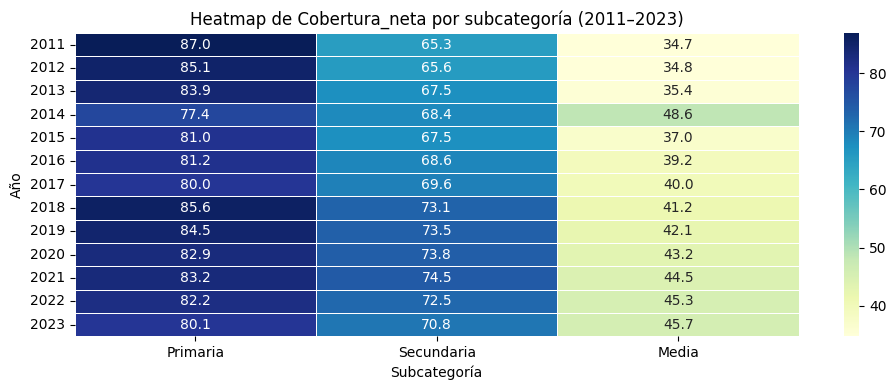

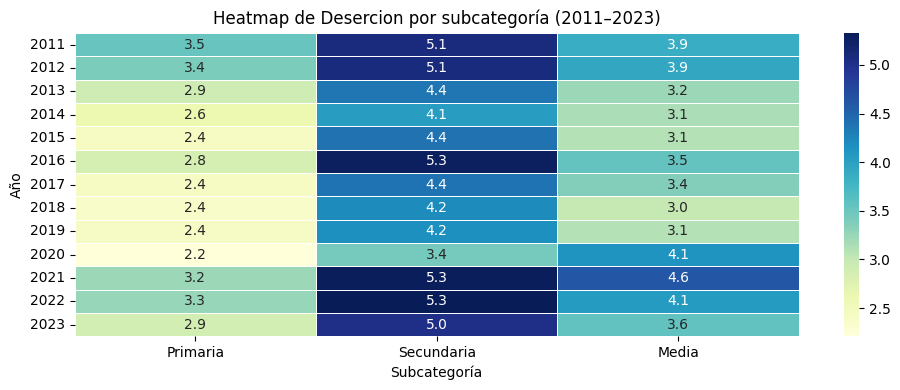

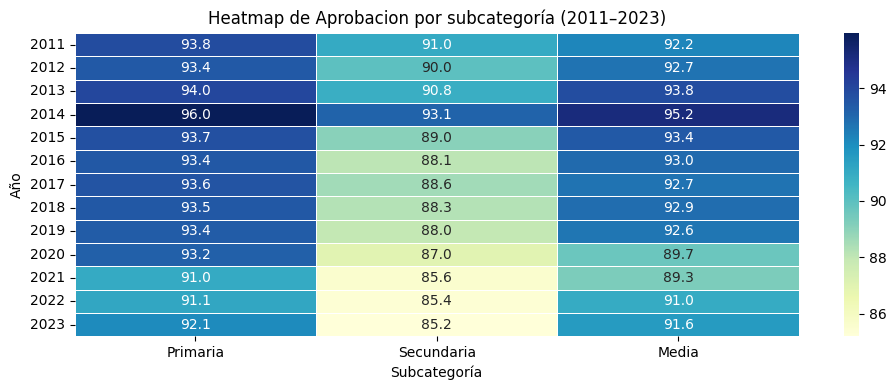

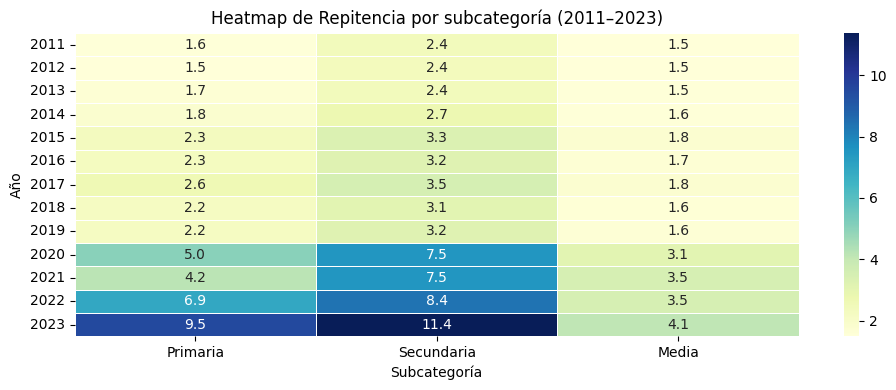

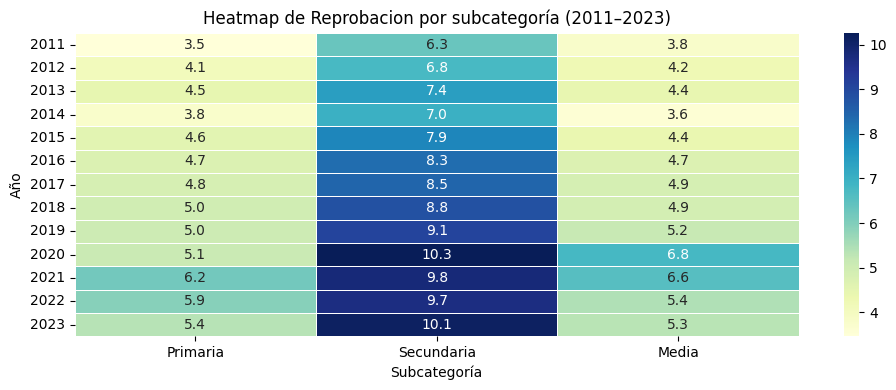

In [104]:
# Heatmap por indicador
for indicador, columnas in subcategorias.items():
    df_heatmap = estadisticas_temporales[['anio'] + columnas].copy()
    df_heatmap.set_index('anio', inplace=True)
    
    # Renombrar columnas para visualización (solo la última parte: TRANSICIÓN, PRIMARIA, etc.)
    df_heatmap.columns = [col.split('_')[-1].capitalize() for col in df_heatmap.columns]

    plt.figure(figsize=(10, 4))
    sns.heatmap(df_heatmap, annot=True, cmap='YlGnBu', fmt=".1f", linewidths=0.5)
    plt.title(f'Heatmap de {indicador.lower().capitalize()} por subcategoría (2011–2023)')
    plt.ylabel('Año')
    plt.xlabel('Subcategoría')
    plt.tight_layout()
    plt.show()



Basándonos en las tablas de calor, la interpretación general del sistema educativo entre 2011 y 2023 es la siguiente:

En términos de acceso (cobertura), el sistema ha logrado una penetración muy alta en la educación primaria, mientras que la secundaria y media han mostrado un progreso constante en la ampliación de su cobertura, aunque la media sigue siendo el nivel con menor alcance.

Sin embargo, los indicadores de eficiencia interna y calidad revelan desafíos importantes, especialmente a partir de 2020:
- La deserción escolar es mínima en primaria, pero persiste como un problema considerable en la secundaria y media, lo que indica dificultades para retener a los estudiantes.
- En cuanto al rendimiento académico, la aprobación se mantiene muy alta en primaria. No obstante, la secundaria experimenta un deterioro preocupante en sus tasas de aprobación, mientras que la media, aunque también afectada, muestra cierta resiliencia.
- El aspecto más crítico es el aumento drástico de la repitencia (repitición de año) en todos los niveles educativos a partir de 2020, siendo particularmente alarmante en primaria y secundaria. Esto sugiere que un número creciente de estudiantes no logra avanzar de grado satisfactoriamente.
- La reprobación (pérdida de asignaturas o el año) también es una preocupación constante y creciente en la secundaria, aunque en primaria y media, tras un aumento en 2020, se observa una ligera tendencia a la estabilización o disminución en los años más recientes.

Se interpreta entonces, que el sistema educativo colombiano ha expandido su alcance, pero enfrenta serios retos en la calidad y el progreso estudiantil, especialmente acentuados después de 2020, probablemente debido al impacto de la pandemia. La educación secundaria emerge como el nivel con los mayores problemas de retención y rendimiento, mientras que el aumento de la repitencia a nivel general es un indicador clave de dificultades en el aprendizaje o la progresión de los estudiantes.

6.1.2.4 Boxplot para indicadores

In [105]:
from plotly.subplots import make_subplots

# Lista de indicadores y títulos
indicadores = ['cobertura_neta', 'desercion', 'aprobacion', 'repitencia', 'reprobacion']
titulos = {
    'cobertura_neta': 'Cobertura Neta',
    'desercion': 'Deserción',
    'aprobacion': 'Aprobación',
    'repitencia': 'Repitencia',
    'reprobacion': 'Reprobación'
}

# Crear subplots en una cuadrícula de 3 filas y 2 columnas
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[titulos[i] for i in indicadores],
    horizontal_spacing=0.15,
    vertical_spacing=0.12
)

# Colores viridis
from plotly.colors import sample_colorscale
anios_unicos = sorted(df_work['anio'].unique())
anio_colores = dict(zip(anios_unicos, sample_colorscale("Viridis", [i/(len(anios_unicos)-1) for i in range(len(anios_unicos))])))

# Agregar boxplots a cada subplot
for idx, indicador in enumerate(indicadores):
    row = idx // 2 + 1
    col = idx % 2 + 1

    for anio in anios_unicos:
        datos_anio = df_work[df_work['anio'] == anio][indicador]
        fig.add_trace(
            go.Box(
                y=datos_anio,
                name=str(anio),
                marker_color=anio_colores[anio],
                boxpoints='outliers',
                line=dict(width=1),
                showlegend=(idx == 0)
            ),
            row=row,
            col=col
        )

# Personalización de estilo
fig.update_layout(
    height=900,
    width=1000,
    title_text="Distribución de Indicadores Educativos por Año",
    template="plotly_white",
    font=dict(size=12),
    legend_title_text='Año',
    margin=dict(t=80)
)

fig.update_yaxes(title_text="Valor (%)")

fig.show()


| **Aspecto Analizado**                                | **Condición y Tendencia General**                                                                                              | **Implicación Principal**                                                                                      |
| ---------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------- |
| **Cobertura Educativa**                              | Avance Significativo: El sistema ha logrado una expansión notable en el acceso a la educación.                                 | Más estudiantes están siendo incorporados al sistema educativo.                                                |
| **Retención (Deserción)**                            | Buena Capacidad: Las tasas de deserción se han mantenido relativamente bajas y estables.                                       | El sistema logra retener a la mayoría de los estudiantes una vez matriculados.                                 |
| **Rendimiento Académico (Repitencia y Reprobación)** | Desafío Creciente y Preocupante: Aumento sostenido y crítico en tasas de repitencia y reprobación, especialmente en 2020-2021. | A pesar de más estudiantes en aulas, muchos no logran los resultados esperados ni aprueban.                    |
| **Conclusión General**                               | Progreso en Cantidad, Reto en Calidad: Colombia ha avanzado en inclusión educativa.                                            | Es crucial mejorar la efectividad del proceso educativo y el logro de competencias por parte del estudiantado. |

6.1.2.5 Matriz correlación Spearman (Mapa de calor)

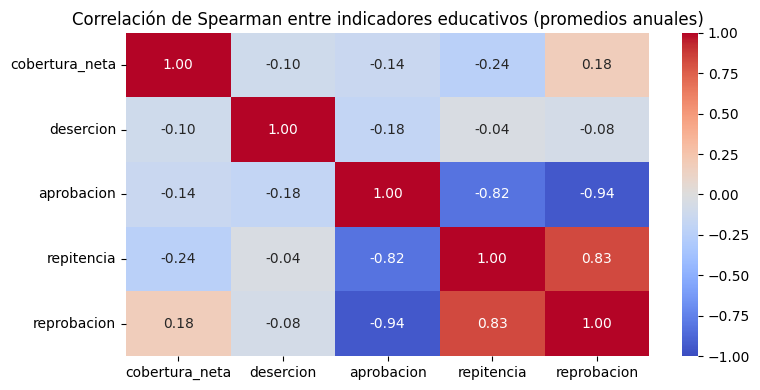

In [106]:
# Definir explícitamente los indicadores a analizar
indicadores_clave = ['cobertura_neta', 'desercion', 'aprobacion', 'repitencia', 'reprobacion']

# Agrupar por año y calcular promedio
df_mean_by_year = df_work.groupby('anio')[indicadores_clave].mean()

# Calcular matriz de correlación con método Spearman
corr_spearman = df_mean_by_year.corr(method='spearman')

# Visualizar el heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación de Spearman entre indicadores educativos (promedios anuales)')
plt.tight_layout()
plt.show()


🔍 Relaciones destacadas
1. Aprobación vs. Reprobación y Repitencia
- Existe una correlación negativa fuerte entre aprobación y reprobación (-0.94) y entre aprobación y repitencia (-0.82).
- Esto significa que en los municipios donde la tasa de aprobación es más alta, los niveles de reprobación y repitencia son significativamente más bajos.
- Es un hallazgo esperado: si más estudiantes aprueban, menos necesitan repetir o reprobar.
2. Repitencia y Reprobación están estrechamente relacionadas
- Su correlación positiva alta (0.83) sugiere que los municipios donde hay más estudiantes repitiendo el curso, también tienen más estudiantes reprobando.
- Esto podría indicar deficiencias en el sistema de apoyo para los estudiantes en riesgo.
3. Cobertura vs. Otros Indicadores
- Cobertura neta tiene correlaciones relativamente débiles con los demás indicadores (-0.09 con deserción, -0.09 con aprobación, -0.28 con repitencia y +0.11 con reprobación).
- Esto sugiere que la cobertura educativa no tiene un impacto fuerte en la probabilidad de aprobación, repitencia o deserción.
- Es posible que otros factores como calidad educativa, recursos o condiciones socioeconómicas tengan más peso.
4. Deserción y Aprobación
- La correlación negativa (-0.18) entre deserción y aprobación indica que los municipios con más deserción suelen tener menos estudiantes aprobando.
- Aunque no es una relación fuerte, sugiere que mejorar los niveles de aprobación podría ayudar a reducir la deserción.


6.1.2.6 Distribución densidad entre 2020 y 2023

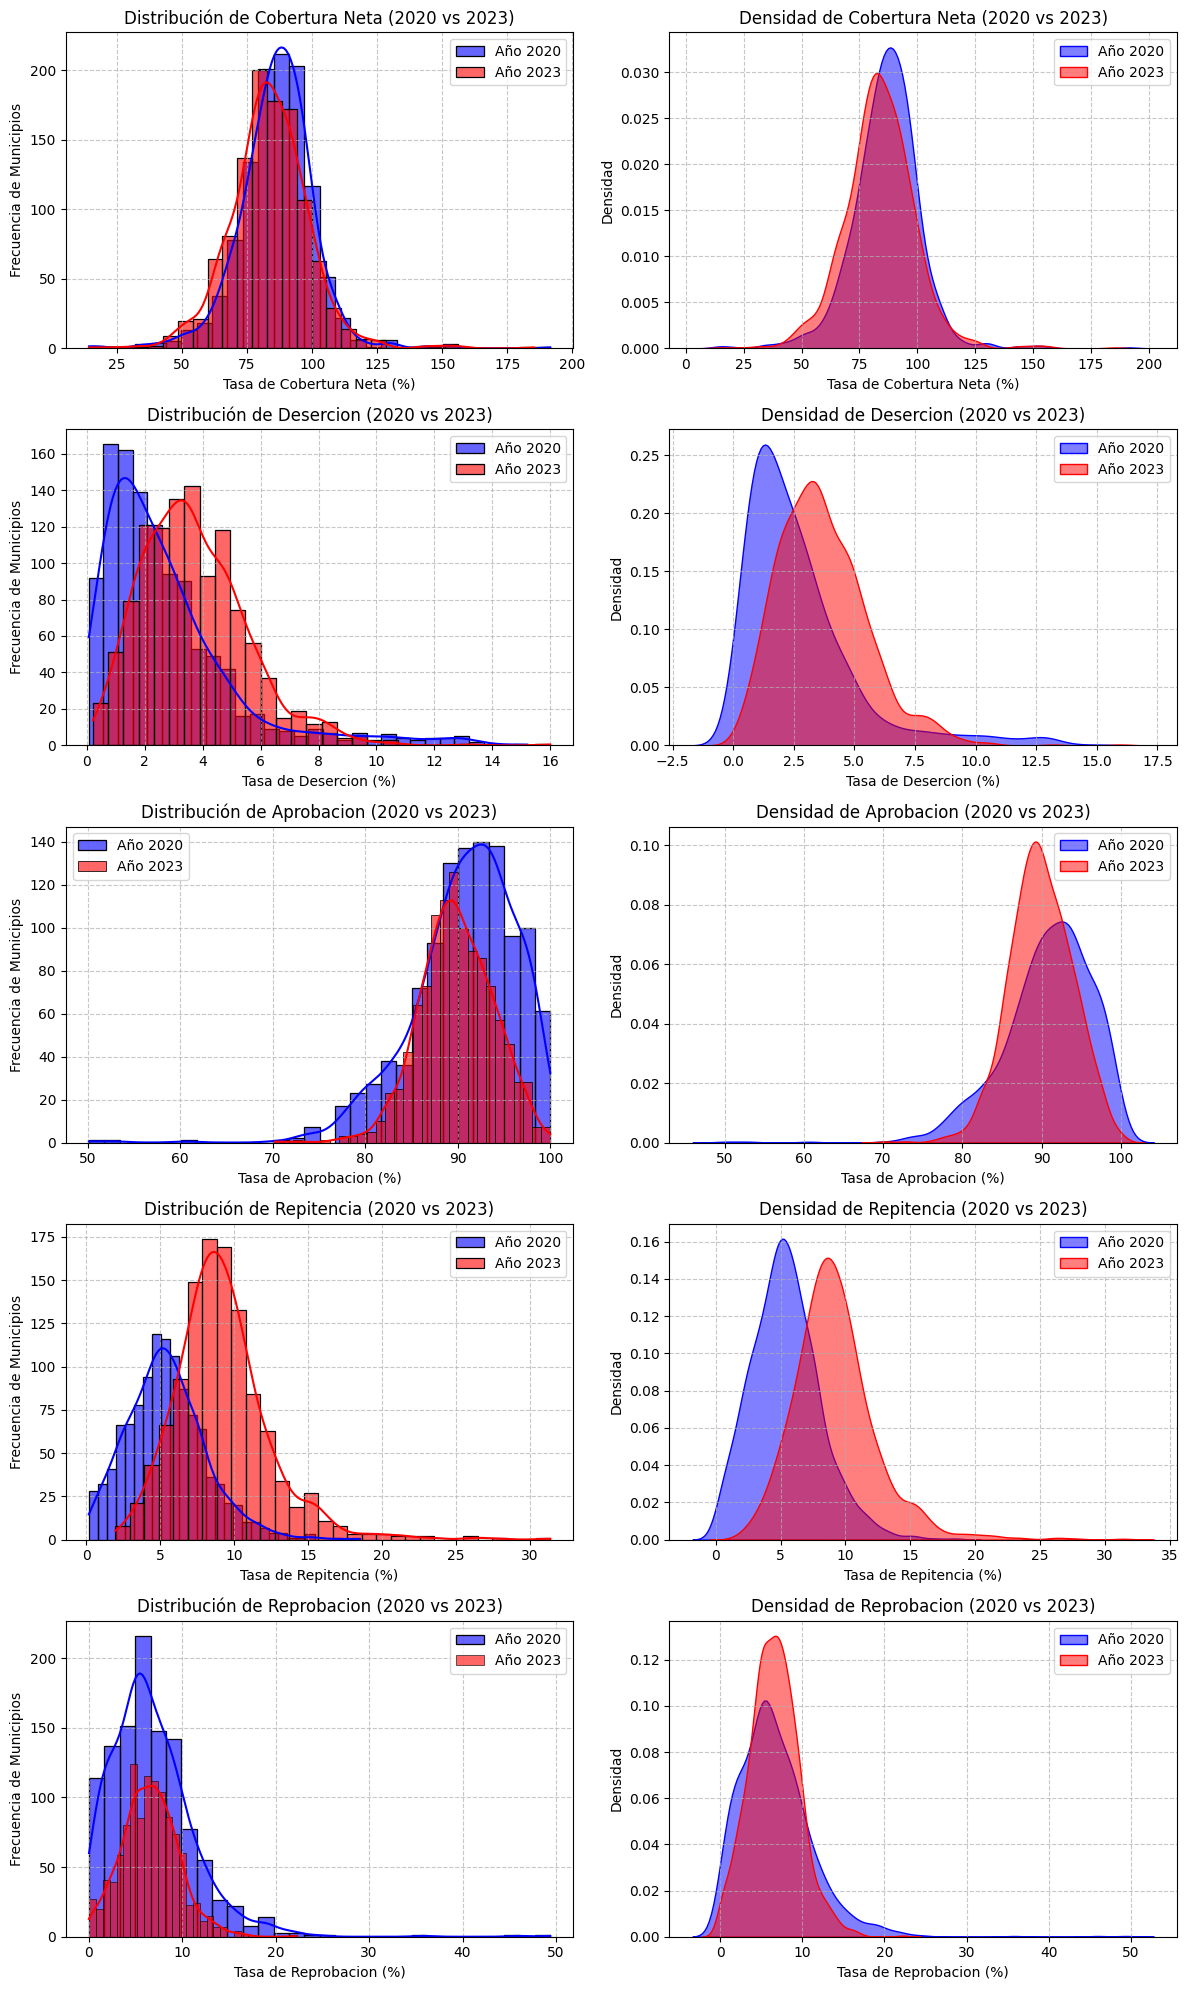

In [107]:
# Seleccionar años de interés
año_inicio = 2020
año_fin = 2023

# Lista de indicadores a evaluar
indicadores = ["cobertura_neta", "desercion", "aprobacion", "repitencia", "reprobacion"]

# Crear figura con múltiples subgráficos organizados en filas de dos gráficos
fig, axes = plt.subplots(nrows=len(indicadores), ncols=2, figsize=(12, len(indicadores) * 4))

for i, indicador in enumerate(indicadores):
    # Gráfico de distribución
    sns.histplot(df_work[df_work["anio"] == año_inicio][indicador].dropna(),
                 kde=True, color="blue", label=f"Año {año_inicio}", alpha=0.6, bins=30, ax=axes[i, 0])
    sns.histplot(df_work[df_work["anio"] == año_fin][indicador].dropna(),
                 kde=True, color="red", label=f"Año {año_fin}", alpha=0.6, bins=30, ax=axes[i, 0])

    axes[i, 0].set_title(f"Distribución de {indicador.replace('_', ' ').title()} ({año_inicio} vs {año_fin})")
    axes[i, 0].set_xlabel(f"Tasa de {indicador.replace('_', ' ').title()} (%)")
    axes[i, 0].set_ylabel("Frecuencia de Municipios")
    axes[i, 0].legend()
    axes[i, 0].grid(True, linestyle="--", alpha=0.7)

    # Gráfico de densidad
    sns.kdeplot(df_work[df_work["anio"] == año_inicio][indicador].dropna(),
                color="blue", label=f"Año {año_inicio}", fill=True, alpha=0.5, ax=axes[i, 1])
    sns.kdeplot(df_work[df_work["anio"] == año_fin][indicador].dropna(),
                color="red", label=f"Año {año_fin}", fill=True, alpha=0.5, ax=axes[i, 1])

    axes[i, 1].set_title(f"Densidad de {indicador.replace('_', ' ').title()} ({año_inicio} vs {año_fin})")
    axes[i, 1].set_xlabel(f"Tasa de {indicador.replace('_', ' ').title()} (%)")
    axes[i, 1].set_ylabel("Densidad")
    axes[i, 1].legend()
    axes[i, 1].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Las gráficas de distribución y densidad confirman y detallan las tendencias observadas en la línea de tiempo. Muestran que los impactos de la pandemia (que inició en 2020 y se extendió hasta 2023) se manifestaron a nivel municipal principalmente en un aumento generalizado en la repitencia y reprobación, y una ligera disminución en la cobertura neta. La deserción, aunque con un leve aumento, mantuvo una distribución más concentrada en valores bajos. Esto refuerza la idea de que la crisis sanitaria generó brechas en el aprendizaje y la progresión académica.

6.2 Análisis Territorial y de Segmentación (Objetivo Específico 2): Identificar patrones y brechas territoriales en los indicadores educativos mediante técnicas de análisis exploratorio y segmentación, como el clustering.

In [108]:
# Definir la lista de indicadores clave (tasas)
indicadores_clave_tasas = [
    'cobertura_neta', 'cobertura_neta_primaria',
    'cobertura_neta_secundaria', 'cobertura_neta_media',
    'desercion', 'desercion_primaria',
    'desercion_secundaria', 'desercion_media',
    'aprobacion', 'aprobacion_primaria',
    'aprobacion_secundaria', 'aprobacion_media',
    'repitencia', 'repitencia_primaria',
    'repitencia_secundaria', 'repitencia_media',
    'reprobacion', 'reprobacion_primaria',
    'reprobacion_secundaria', 'reprobacion_media'
]

# Definir las características que se usarán para el clustering, incluyendo poblacion_5_16
features_for_clustering = indicadores_clave_tasas + ['poblacion_5_16']

print("Características seleccionadas para el clustering:", features_for_clustering)

Características seleccionadas para el clustering: ['cobertura_neta', 'cobertura_neta_primaria', 'cobertura_neta_secundaria', 'cobertura_neta_media', 'desercion', 'desercion_primaria', 'desercion_secundaria', 'desercion_media', 'aprobacion', 'aprobacion_primaria', 'aprobacion_secundaria', 'aprobacion_media', 'repitencia', 'repitencia_primaria', 'repitencia_secundaria', 'repitencia_media', 'reprobacion', 'reprobacion_primaria', 'reprobacion_secundaria', 'reprobacion_media', 'poblacion_5_16']


In [109]:
#Seleccionar variables numéricas relevantes
df_cluster_data = df_work.groupby('municipio')[features_for_clustering].mean().dropna()
#Estandarizar
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster_data)

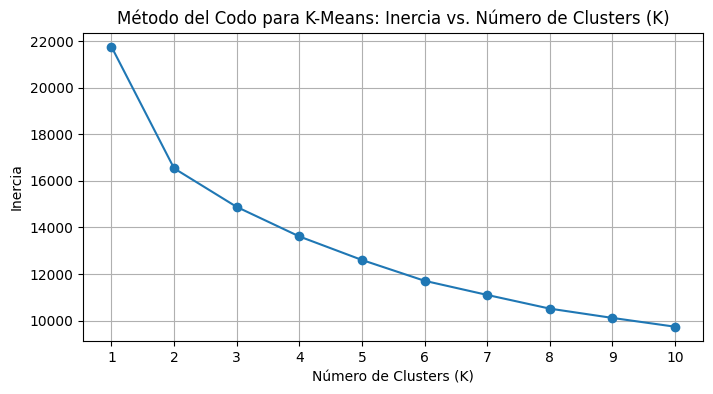

In [110]:
inertias = []
# rango de posibles números de clusters
for i in range(1, 11): 
    kmeans_test = KMeans(n_clusters=i, random_state=42, n_init=10) # n_init para reproducibilidad
    kmeans_test.fit(df_scaled)
    inertias.append(kmeans_test.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Método del Codo para K-Means: Inercia vs. Número de Clusters (K)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

Se aplica el método del codo para K-Means con el fin de determinar el número óptimo de clusters en este caso, se produce el "codo" en 4.


In [111]:
# Aplicar K-Means con el número óptimo de clusters (basado en el codo, usamos 4)
optimal_k = 4 
print(f"\nNúmero óptimo de clusters elegido (según Método del Codo): {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_scaled)

# Asignar las etiquetas de cluster de vuelta al DataFrame de datos promedios municipales
df_municipios_con_cluster = df_cluster_data.copy()
df_municipios_con_cluster['Cluster'] = cluster_labels
df_municipios_con_cluster = df_municipios_con_cluster.reset_index()

print(f"\nClustering K-Means completado y etiquetas asignadas a {optimal_k} clusters.")
print("Conteo de municipios por cluster:\n", df_municipios_con_cluster['Cluster'].value_counts())



Número óptimo de clusters elegido (según Método del Codo): 4

Clustering K-Means completado y etiquetas asignadas a 4 clusters.
Conteo de municipios por cluster:
 Cluster
3    371
0    275
2    253
1    137
Name: count, dtype: int64


In [115]:
# Si ya existe la columna 'Cluster' en df_work, la eliminamos para evitar conflictos
if 'Cluster' in df_work.columns:
    df_work = df_work.drop(columns=['Cluster'])

# Realizamos el merge para agregar el Cluster desde df_municipios_con_cluster
df_work = df_work.merge(
    df_municipios_con_cluster[['municipio', 'Cluster']],
    on='municipio',
    how='left'
)

# Ahora df_work tiene solo una columna 'Cluster' (la correcta del DataFrame de clusters)


In [116]:
print(df_work.columns)

Index(['anio', 'codigo_municipio', 'municipio', 'codigo_departamento',
       'departamento', 'codigo_etc', 'etc', 'poblacion_5_16',
       'tasa_matriculacion_5_16', 'cobertura_neta', 'cobertura_neta_primaria',
       'cobertura_neta_secundaria', 'cobertura_neta_media', 'cobertura_bruta',
       'cobertura_bruta_primaria', 'cobertura_bruta_secundaria',
       'cobertura_bruta_media', 'desercion', 'desercion_primaria',
       'desercion_secundaria', 'desercion_media', 'aprobacion',
       'aprobacion_primaria', 'aprobacion_secundaria', 'aprobacion_media',
       'reprobacion', 'reprobacion_primaria', 'reprobacion_secundaria',
       'reprobacion_media', 'repitencia', 'repitencia_primaria',
       'repitencia_secundaria', 'repitencia_media', 'Cluster'],
      dtype='object')


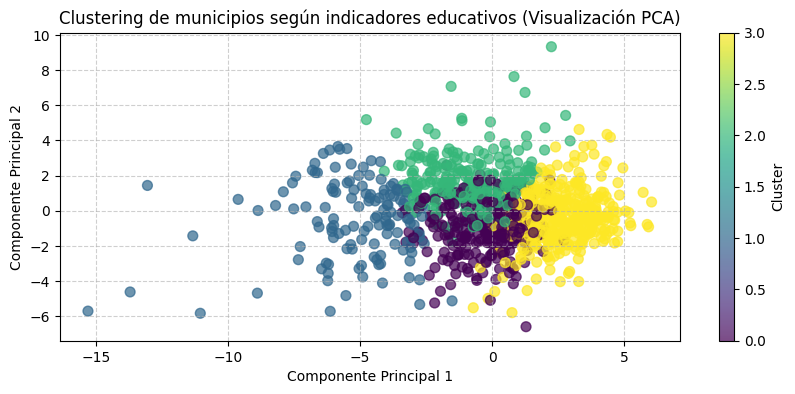


Visualización PCA de los clusters generada.


In [117]:
#Visualizar los Clusters con PCA 
pca = PCA(n_components=2)
coords = pca.fit_transform(df_scaled) # PCA siempre usa los datos escalados

plt.figure(figsize=(10, 4)) # Aumenté un poco el tamaño para mejor visualización
plt.scatter(coords[:,0], coords[:,1], c=df_municipios_con_cluster['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title("Clustering de municipios según indicadores educativos (Visualización PCA)") # Título un poco más descriptivo
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nVisualización PCA de los clusters generada.")

🔍 Observaciones sobre el clustering

- Se formaron 4 grupos de municipios (clusters), cada uno con características educativas parecidas:

Cluster amarillo (grupo 3):

- Está bien separado del resto.
- Probablemente representa municipios con mejores condiciones educativas (alta cobertura, baja deserción, buen rendimiento).

Cluster azul (grupo 1):

- Es el más disperso.
- Podría incluir municipios con mayores dificultades educativas.

Clusters verde (2) y morado (0):

- Están más mezclados.
- Representan municipios con condiciones intermedias o diversas en términos de educación.



--- Perfiles Promedio de los Clusters (Valores sin escalar) ---
         cobertura_neta  cobertura_neta_primaria  cobertura_neta_secundaria  \
Cluster                                                                       
0                 83.47                    81.24                      63.75   
1                 80.61                    79.84                      58.19   
2                 91.73                    88.24                      79.74   
3                 85.21                    81.19                      72.72   

         cobertura_neta_media  desercion  desercion_primaria  \
Cluster                                                        
0                       34.46       4.25                3.48   
1                       28.89       5.17                4.20   
2                       48.61       3.25                2.50   
3                       44.97       2.48                2.00   

         desercion_secundaria  desercion_media  aprobacion  \
Cluster      

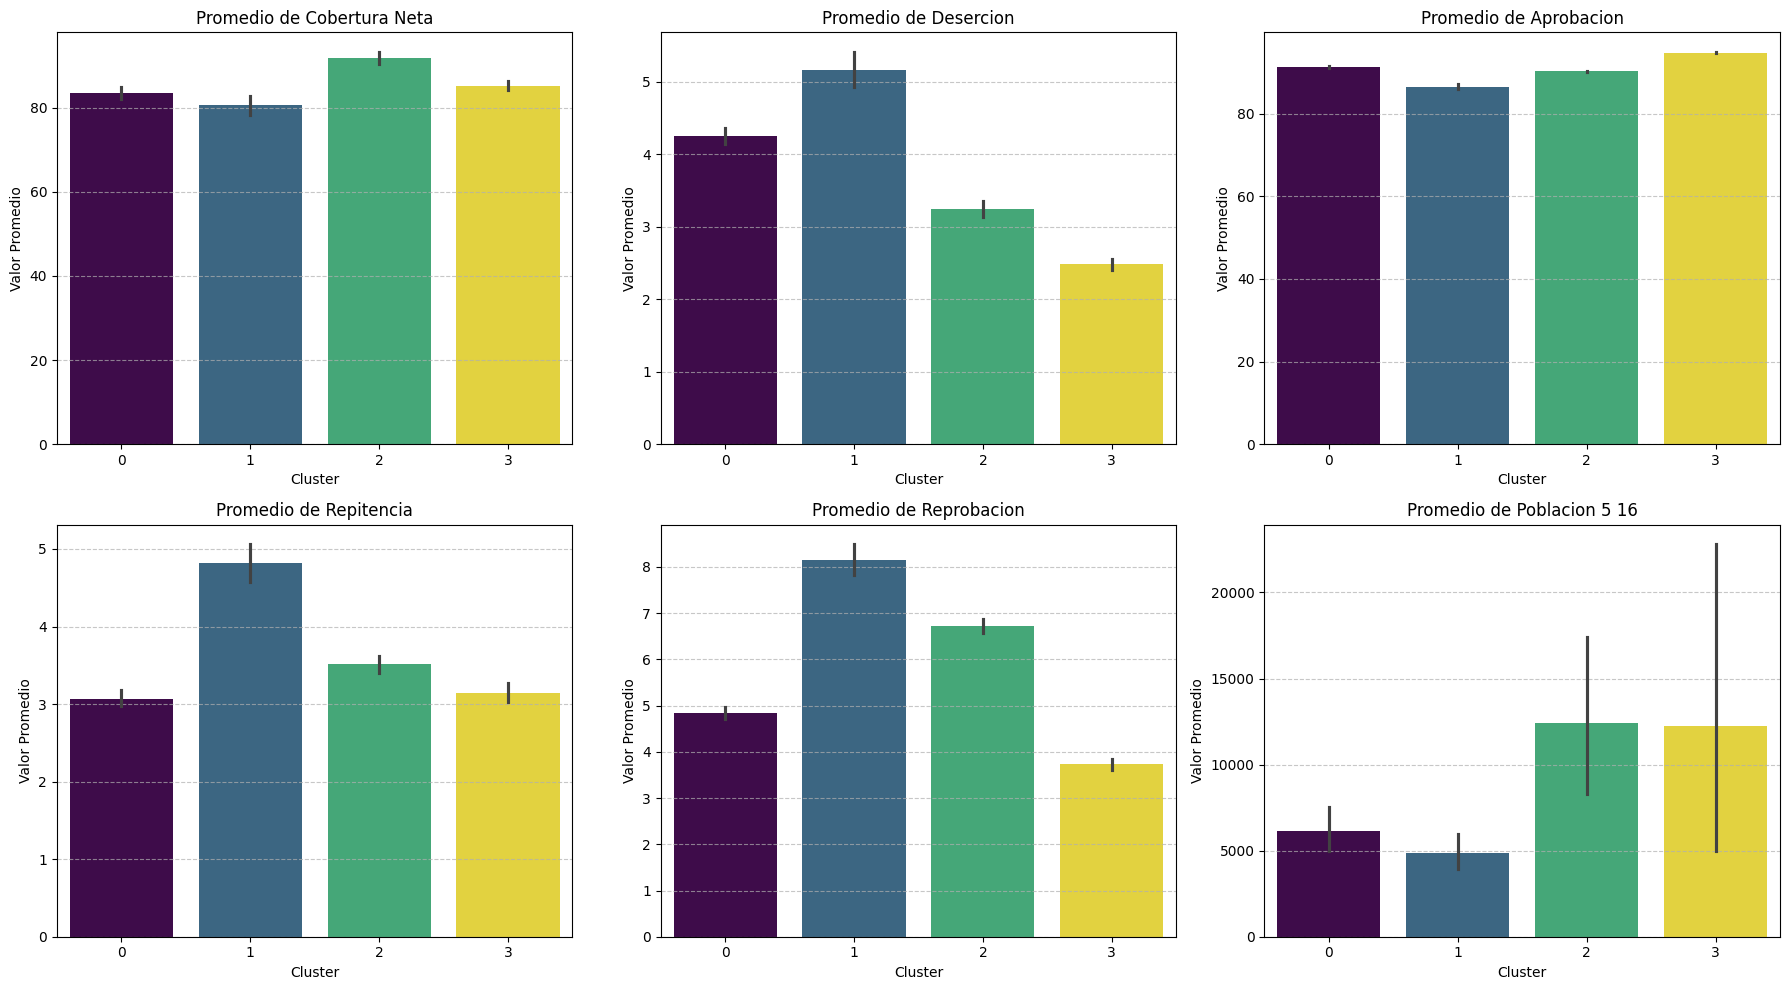


--- Boxplots para Distribución de Indicadores por Cluster ---


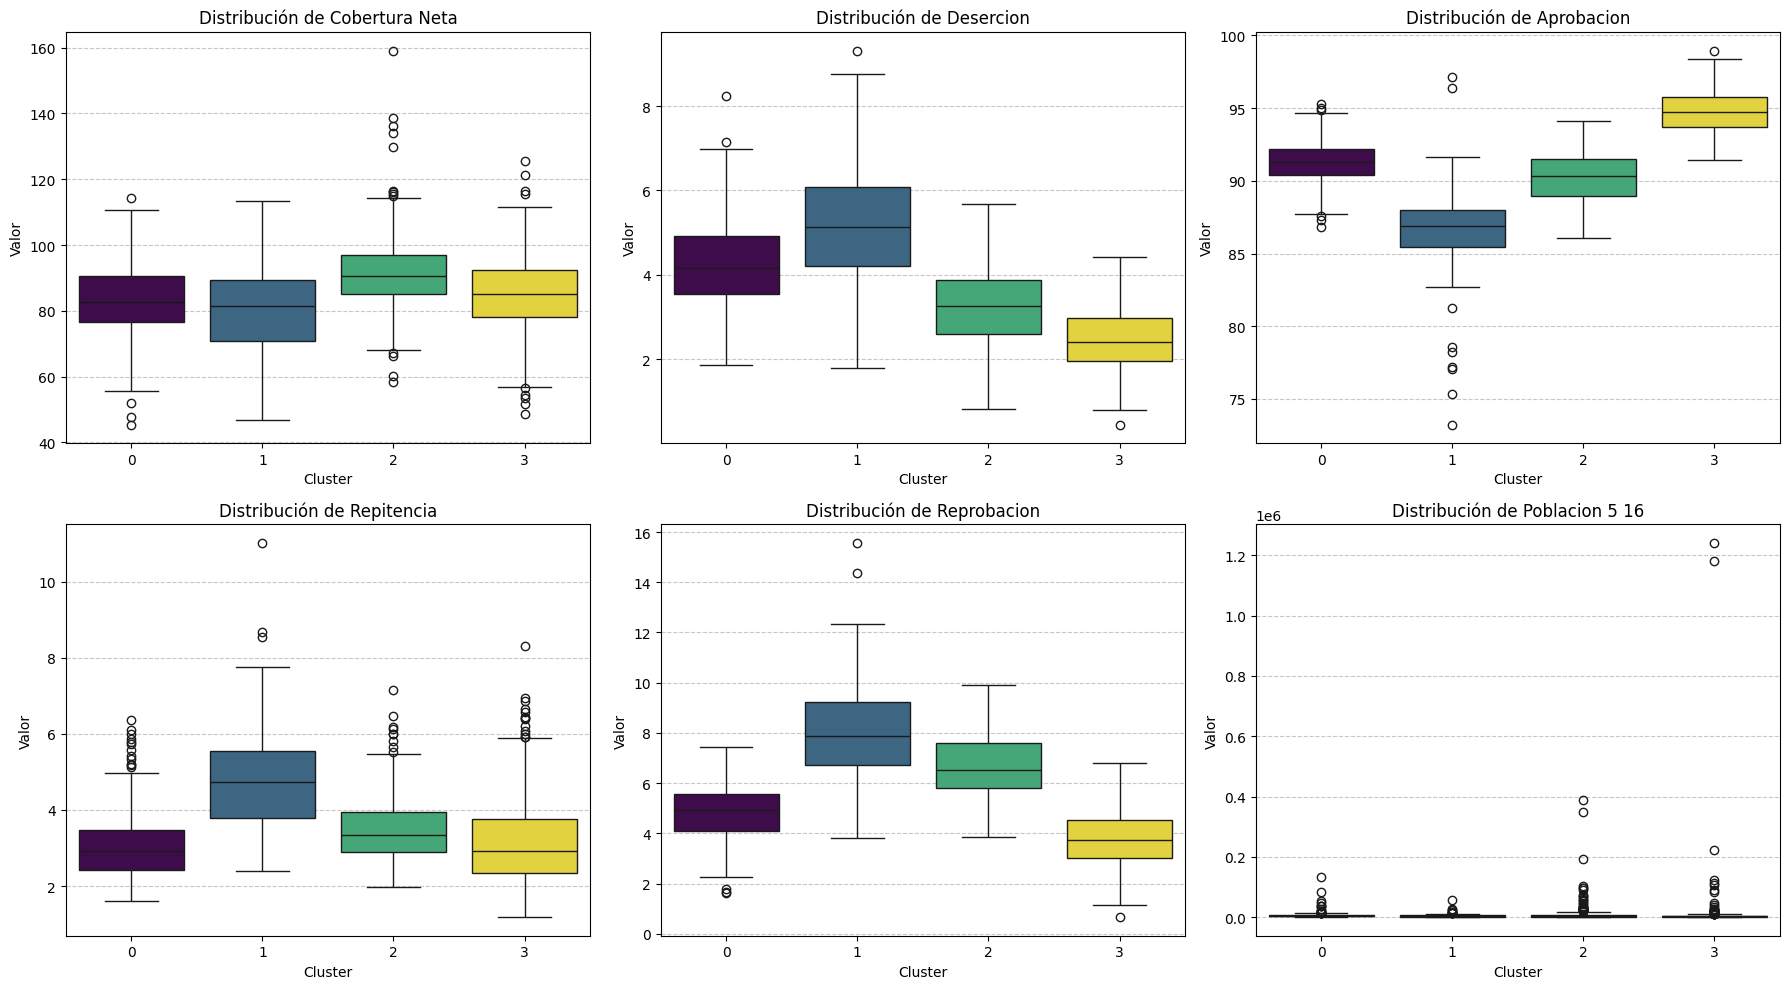


--- CARACTERIZACIÓN DE CLUSTERS FINALIZADA ---
Ahora puedes interpretar los perfiles de cada cluster y proceder con la validación Kruskall-Wallis.


In [ ]:
# 1. Caracterización Numérica: Promedios y Medianas por Cluster
print("\n--- Perfiles Promedio de los Clusters (Valores sin escalar) ---")
cluster_means = df_municipios_con_cluster.groupby('Cluster')[features_for_clustering].mean()
print(cluster_means.round(2))

print("\n--- Perfiles Mediana de los Clusters (Valores sin escalar) ---")
cluster_medians = df_municipios_con_cluster.groupby('Cluster')[features_for_clustering].median()
print(cluster_medians.round(2))

# Indicadores clave para visualización
indicadores_principales_viz = [
    'cobertura_neta',
    'desercion',
    'aprobacion',
    'repitencia',
    'reprobacion',
    'poblacion_5_16'
]

# 2. Gráficos de Barras organizados en subplots (filas de 3)
print("\n--- Promedios por Cluster (Gráficos de Barras) ---")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, indicador in enumerate(indicadores_principales_viz):
    sns.barplot(
        x='Cluster',
        y=indicador,
        data=df_municipios_con_cluster,
        hue='Cluster',
        palette='viridis',
        legend=False,
        ax=axes[i]
    )
    axes[i].set_title(f'Promedio de {indicador.replace("_", " ").title()}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Valor Promedio')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Si hay un subplot extra, lo ocultamos
if len(indicadores_principales_viz) < len(axes):
    for j in range(len(indicadores_principales_viz), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 3. Boxplots organizados en subplots (filas de 3)
print("\n--- Boxplots para Distribución de Indicadores por Cluster ---")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, indicador in enumerate(indicadores_principales_viz):
    sns.boxplot(
        x='Cluster',
        y=indicador,
        data=df_municipios_con_cluster,
        hue='Cluster',
        palette='viridis',
        legend=False,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribución de {indicador.replace("_", " ").title()}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Valor')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

if len(indicadores_principales_viz) < len(axes):
    for j in range(len(indicadores_principales_viz), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("\n--- CARACTERIZACIÓN DE CLUSTERS FINALIZADA ---")
print("Ahora puedes interpretar los perfiles de cada cluster y proceder con la validación Kruskall-Wallis.")


Los 4 clusters identificados revelan claros perfiles de desempeño educativo a nivel municipal. Se observa una clara distinción entre municipios con grandes desafíos (Cluster 0 y Cluster 1), donde la combinación de baja cobertura, alta deserción y bajo rendimiento académico es prevalente, y municipios con buen o excelente desempeño (Cluster 2 y Cluster 3), que logran mantener alta cobertura, baja deserción y altos índices de aprobación con baja repitencia/reprobación.

Esta caracterización es fundamental para diseñar políticas educativas diferenciadas, adaptadas a las necesidades específicas de cada grupo de municipios. Por ejemplo, el Cluster 0 y 1 necesitarían intervenciones urgentes en retención y apoyo académico, mientras que el Cluster 2 y 3 podrían servir de modelo o necesitar estrategias para mantener su excelencia y escalar buenas prácticas.


In [ ]:
#Revisar normalidad de los clusters
from scipy.stats import shapiro

print("🔍 Prueba de normalidad (Shapiro-Wilk) por cluster para 'cobertura_neta':")
for grupo in sorted(df_work['Cluster'].dropna().unique()):
    datos = df_work[df_work['Cluster'] == grupo]['cobertura_neta'].dropna()
    if len(datos) >= 3:
        stat, p = shapiro(datos)
        print(f"Cluster {grupo}: W = {stat:.4f}, p-value = {p:.4f}")
    else:
        print(f"Cluster {grupo}: no hay suficientes datos para la prueba.")


🔍 Prueba de normalidad (Shapiro-Wilk) por cluster para 'cobertura_neta':
Cluster 0: W = 0.9757, p-value = 0.0000
Cluster 1: W = 0.9385, p-value = 0.0000
Cluster 2: W = 0.9076, p-value = 0.0000
Cluster 3: W = 0.9780, p-value = 0.0000


In [ ]:
from scipy.stats import kruskal

print("\n--- INICIANDO ANÁLISIS KRUSKAL-WALLIS PARA VALIDAR BRECHAS ENTRE CLUSTERS (NO PARAMÉTRICO) ---")

# Lista de indicadores para analizar las brechas
indicadores_para_kruskal = [
    'cobertura_neta', 'desercion', 'aprobacion', 'repitencia', 'reprobacion',
]

for ind in indicadores_para_kruskal:
    grupos = []
    
    # Itera sobre los clusters únicos y ordenados
    for cluster_id in sorted(df_municipios_con_cluster['Cluster'].unique()):
        group_data = df_municipios_con_cluster[df_municipios_con_cluster['Cluster'] == cluster_id][ind].dropna()

        if not group_data.empty and len(group_data) > 1:
            grupos.append(group_data)
        else:
            print(f"Advertencia: El Cluster {cluster_id} tiene pocos o ningún dato válido para '{ind}'. Será omitido en Kruskal-Wallis.")

    if len(grupos) > 1:
        h_stat, p_value = kruskal(*grupos)

        print(f"\n--- Resultados Kruskal-Wallis para: {ind.replace('_', ' ').title()} ---")
        print(f"  Estadístico H: {h_stat:.3f}")
        print(f"  P-valor: {p_value:.5f}")

        alpha = 0.05

        if p_value < alpha:
            print(f"  **Conclusión:** Con un P-valor de {p_value:.5f} (menor que {alpha}),")
            print(f"  RECHAZAMOS la hipótesis nula (H0).")
            print(f"  Esto indica que existen diferencias estadísticamente significativas en la")
            print(f"  {ind.replace('_', ' ').lower()} entre al menos algunos de los clusters de municipios.")
            print(f"  Lo anterior respalda la existencia de brechas territoriales en este indicador.")
        else:
            print(f"  **Conclusión:** Con un P-valor de {p_value:.5f} (mayor que {alpha}),")
            print(f"  NO RECHAZAMOS la hipótesis nula (H0).")
            print(f"  No hay suficiente evidencia estadística para afirmar que existen")
            print(f"  diferencias significativas en la {ind.replace('_', ' ').lower()} entre clusters.")
    else:
        print(f"\n--- No se pudo realizar Kruskal-Wallis para {ind.replace('_', ' ').title()} ---")
        print("  Razón: No hay suficientes grupos válidos o datos para comparar.")

print("\n--- ANÁLISIS KRUSKAL-WALLIS FINALIZADO ---")
print("Estos p-valores son clave para validar las brechas territoriales cuando los datos no son normales.")



--- INICIANDO ANÁLISIS KRUSKAL-WALLIS PARA VALIDAR BRECHAS ENTRE CLUSTERS (NO PARAMÉTRICO) ---

--- Resultados Kruskal-Wallis para: Cobertura Neta ---
  Estadístico H: 88.985
  P-valor: 0.00000
  **Conclusión:** Con un P-valor de 0.00000 (menor que 0.05),
  RECHAZAMOS la hipótesis nula (H0).
  Esto indica que existen diferencias estadísticamente significativas en la
  cobertura neta entre al menos algunos de los clusters de municipios.
  Lo anterior respalda la existencia de brechas territoriales en este indicador.

--- Resultados Kruskal-Wallis para: Desercion ---
  Estadístico H: 531.831
  P-valor: 0.00000
  **Conclusión:** Con un P-valor de 0.00000 (menor que 0.05),
  RECHAZAMOS la hipótesis nula (H0).
  Esto indica que existen diferencias estadísticamente significativas en la
  desercion entre al menos algunos de los clusters de municipios.
  Lo anterior respalda la existencia de brechas territoriales en este indicador.

--- Resultados Kruskal-Wallis para: Aprobacion ---
  Estadís

In [ ]:
print(df_work.columns)

Index(['anio', 'codigo_municipio', 'municipio', 'codigo_departamento',
       'departamento', 'codigo_etc', 'etc', 'poblacion_5_16',
       'tasa_matriculacion_5_16', 'cobertura_neta', 'cobertura_neta_primaria',
       'cobertura_neta_secundaria', 'cobertura_neta_media', 'cobertura_bruta',
       'cobertura_bruta_primaria', 'cobertura_bruta_secundaria',
       'cobertura_bruta_media', 'desercion', 'desercion_primaria',
       'desercion_secundaria', 'desercion_media', 'aprobacion',
       'aprobacion_primaria', 'aprobacion_secundaria', 'aprobacion_media',
       'reprobacion', 'reprobacion_primaria', 'reprobacion_secundaria',
       'reprobacion_media', 'repitencia', 'repitencia_primaria',
       'repitencia_secundaria', 'repitencia_media'],
      dtype='object')


In [ ]:
# Ver cuántos municipios hay en el Cluster 3
df_municipios_con_cluster['Cluster'].value_counts()

# Ver los municipios del Cluster 3
df_cluster3 = df_municipios_con_cluster[df_municipios_con_cluster['Cluster'] == 3]
print(df_cluster3[['municipio'] + indicadores_principales_viz])

         municipio  cobertura_neta  desercion  aprobacion  repitencia  \
2         Abriaquí       80.120000   2.180000   94.828462    3.976154   
6             Achí       99.743846   2.595385   95.697692    1.868462   
8     Agua de Dios       89.066154   2.973846   95.016923    4.306923   
10          Aguada       76.890769   1.870769   97.716154    1.954615   
16           Albán       70.355769   3.763077   94.246538    2.367308   
...            ...             ...        ...         ...         ...   
1026      Zambrano       92.363077   2.978462   95.523077    2.142308   
1028       Zapayán       90.281538   2.798462   95.466154    4.686923   
1031     Zetaquira       96.353846   2.361538   93.437692    2.086154   
1032       Zipacón       75.236923   2.869231   95.096923    2.389231   
1035         Útica       74.224615   2.433077   96.296923    3.381538   

      reprobacion  poblacion_5_16  
2        4.576154      465.461538  
6        1.706154     5235.764385  
8        3.1969

6.3 Modelado Predictivo (Objetivo Específico 3): Desarrollar modelos predictivos que permitan anticipar tendencias en cobertura, deserción y repitencia educativa.

6.3.1 Modelo predictivo Prophet


📊 Modelo para: COBERTURA_NETA


15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:51 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
11 2022-01-01  85.388167   63.173241  106.637664
12 2023-01-01  83.723127   63.018255  104.312541
13 2023-12-31  81.218389   61.404197  102.070078
14 2024-12-31  80.414629   59.663598  101.545244
15 2025-12-31  78.771739   56.703478  100.514296


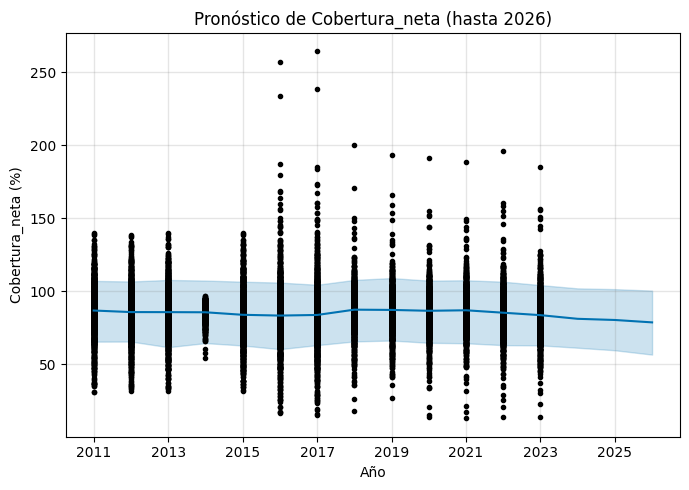

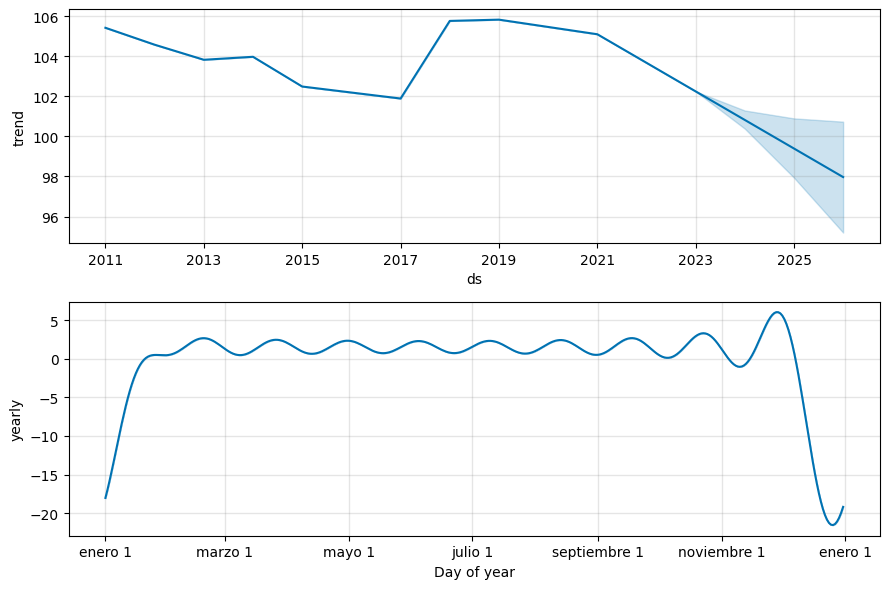


📊 Modelo para: DESERCION


15:18:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:01 - cmdstanpy - INFO - Chain [1] done processing


           ds      yhat  yhat_lower  yhat_upper
11 2022-01-01  3.930412    1.363433    6.660797
12 2023-01-01  3.799947    1.243173    6.611636
13 2023-12-31  3.878762    1.244800    6.558296
14 2024-12-31  3.538064    0.713338    6.242183
15 2025-12-31  3.406518    0.600108    6.100133


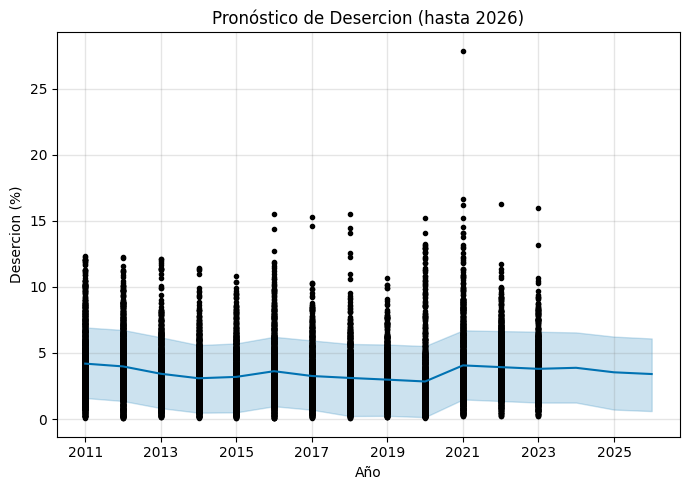

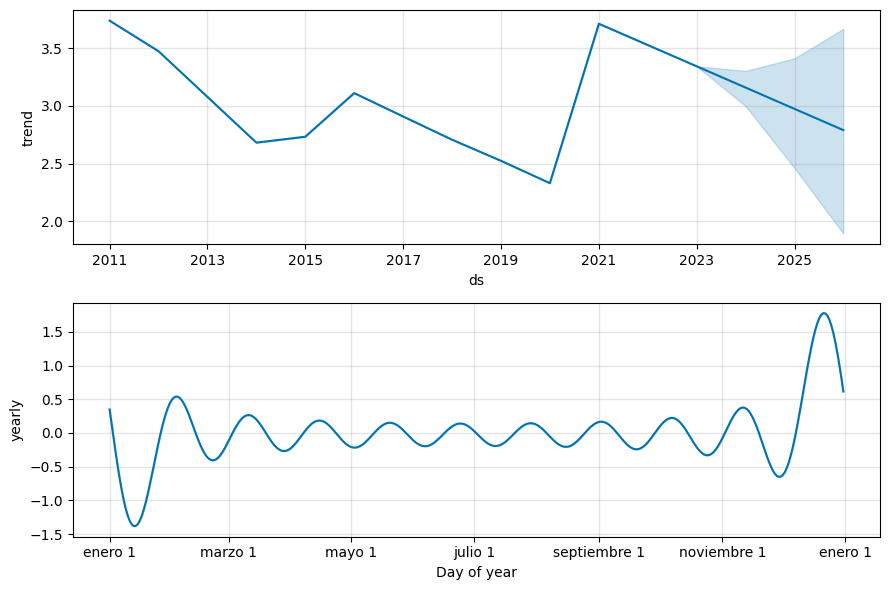


📊 Modelo para: APROBACION


15:19:05 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
11 2022-01-01  89.485405   83.330866   95.804600
12 2023-01-01  89.788558   83.821505   95.894819
13 2023-12-31  90.405442   84.577590   96.865263
14 2024-12-31  90.394332   84.080784   96.670135
15 2025-12-31  90.696764   84.219815   98.196007


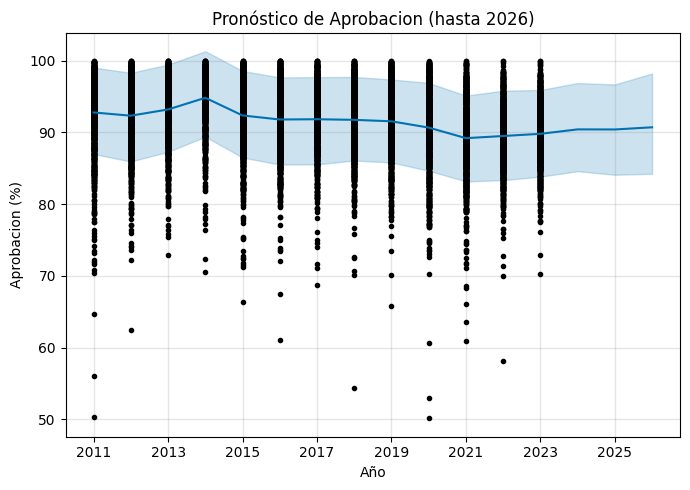

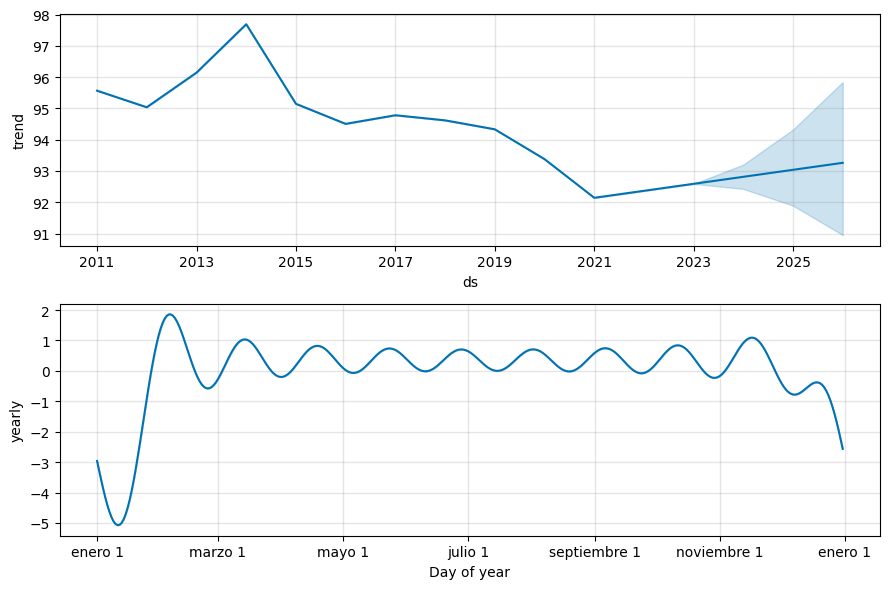


📊 Modelo para: REPITENCIA


15:19:13 - cmdstanpy - INFO - Chain [1] start processing
15:19:21 - cmdstanpy - INFO - Chain [1] done processing


           ds       yhat  yhat_lower  yhat_upper
11 2022-01-01   6.998557    4.059118    9.983456
12 2023-01-01   9.015897    5.937378   12.022708
13 2023-12-31  11.439909    8.439893   14.575838
14 2024-12-31  13.077061    9.789122   16.006415
15 2025-12-31  15.120667   11.647521   18.679193


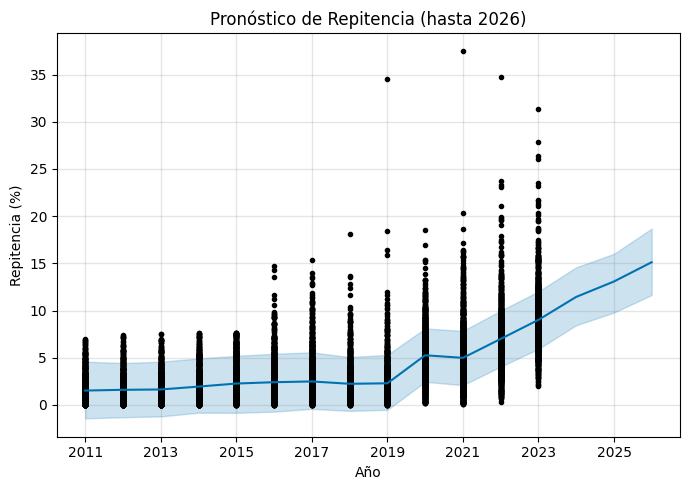

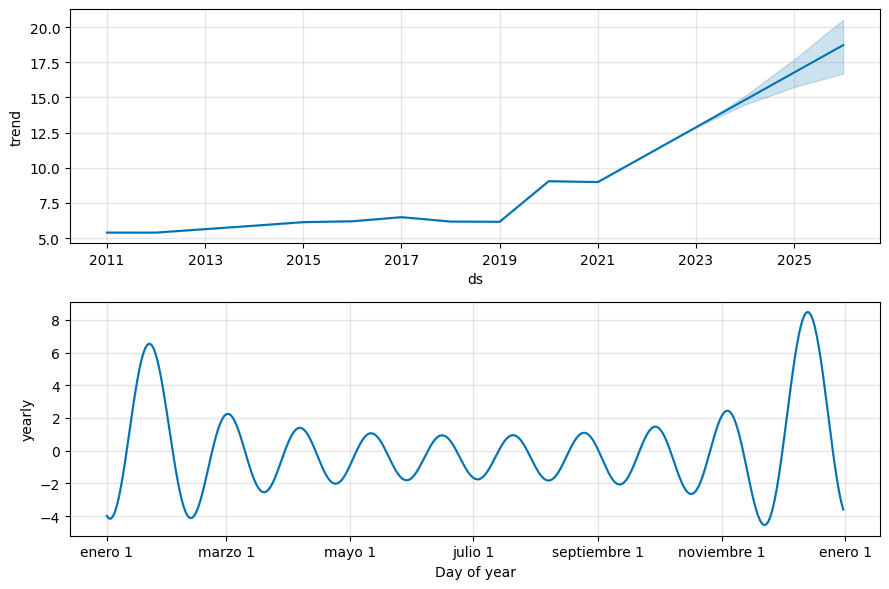


📊 Modelo para: REPROBACION


15:19:23 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing


           ds      yhat  yhat_lower  yhat_upper
11 2022-01-01  6.722890    2.693362   11.349910
12 2023-01-01  6.585717    1.926082   10.779907
13 2023-12-31  6.581351    2.148946   10.925254
14 2024-12-31  6.314595    1.968370   11.078251
15 2025-12-31  6.180567    1.642443   10.623090


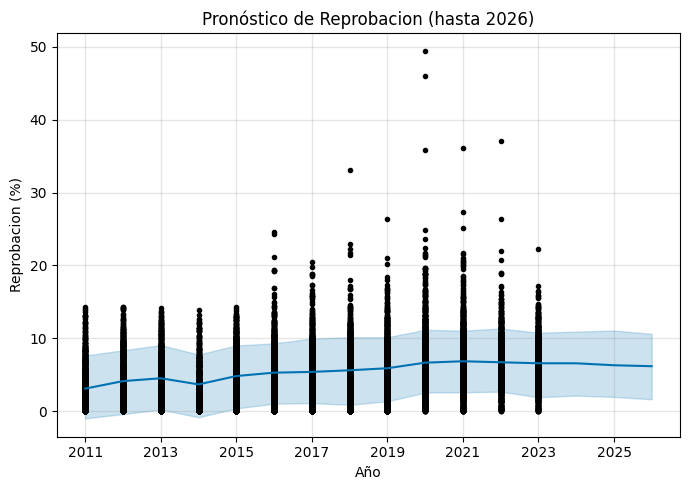

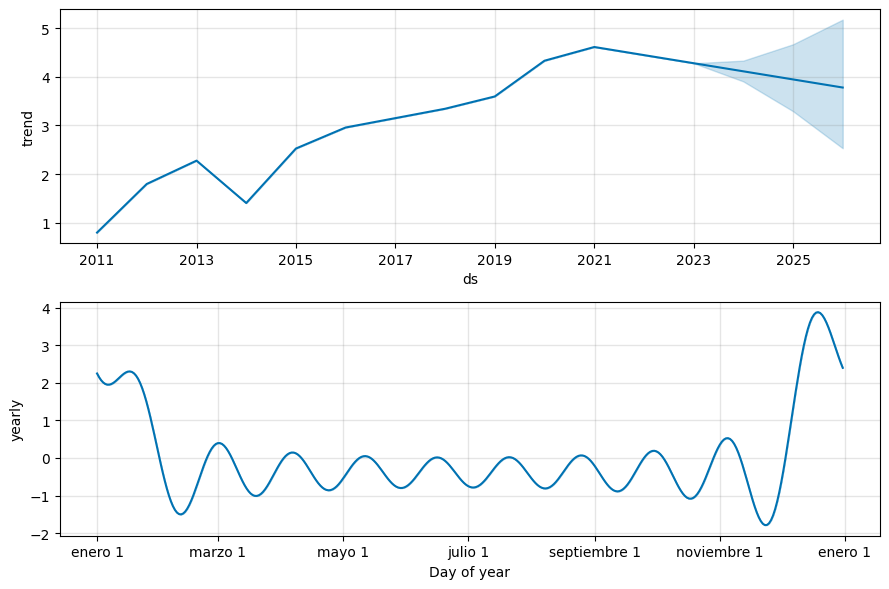

In [ ]:
# Lista de indicadores
indicadores = ['cobertura_neta', 'desercion', 'aprobacion', 'repitencia', 'reprobacion']
 
for indicador in indicadores:
    print(f'\n📊 Modelo para: {indicador.upper()}')
 
    # Preparar datos
    df_prophet = df_work[['anio', indicador]].rename(columns={'anio': 'ds', indicador: 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')
 
    # Calcular años a predecir hasta 2026
    ultimo_anio = df_prophet['ds'].max().year
    anios_a_predecir = 2026 - ultimo_anio
 
    # Crear y entrenar modelo Prophet
    model = Prophet()
    model.fit(df_prophet)
 
    # Crear fechas futuras hasta 2026
    future = model.make_future_dataframe(periods=anios_a_predecir, freq='Y')
    forecast = model.predict(future)
 
    # Mostrar últimos valores
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
 
    # Graficar pronóstico
    fig, ax = plt.subplots(figsize=(7, 5))
    model.plot(forecast, ax=ax)
    ax.set_title(f'Pronóstico de {indicador.capitalize()} (hasta 2026)')
    ax.set_xlabel('Año')
    ax.set_ylabel(f'{indicador.capitalize()} (%)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
 
    # Graficar componentes
    model.plot_components(forecast)
    plt.tight_layout()
    plt.show()
 

De acuerdo al Modelo Predictivo Prophet, se establecen las siguientes observaciones: 
1. La aprobación se mantiene fuerte, lo cual es positivo.
2. La repitencia y la reprobación deben monitorearse: una sube y la otra baja levemente, pero ambas pueden afectar la eficiencia escolar.
3. La cobertura neta y la deserción tienen un comportamiento incierto; aunque bajan, los intervalos son tan amplios que dificultan conclusiones firmes.

6.3.2 Modelo predictivo Arima

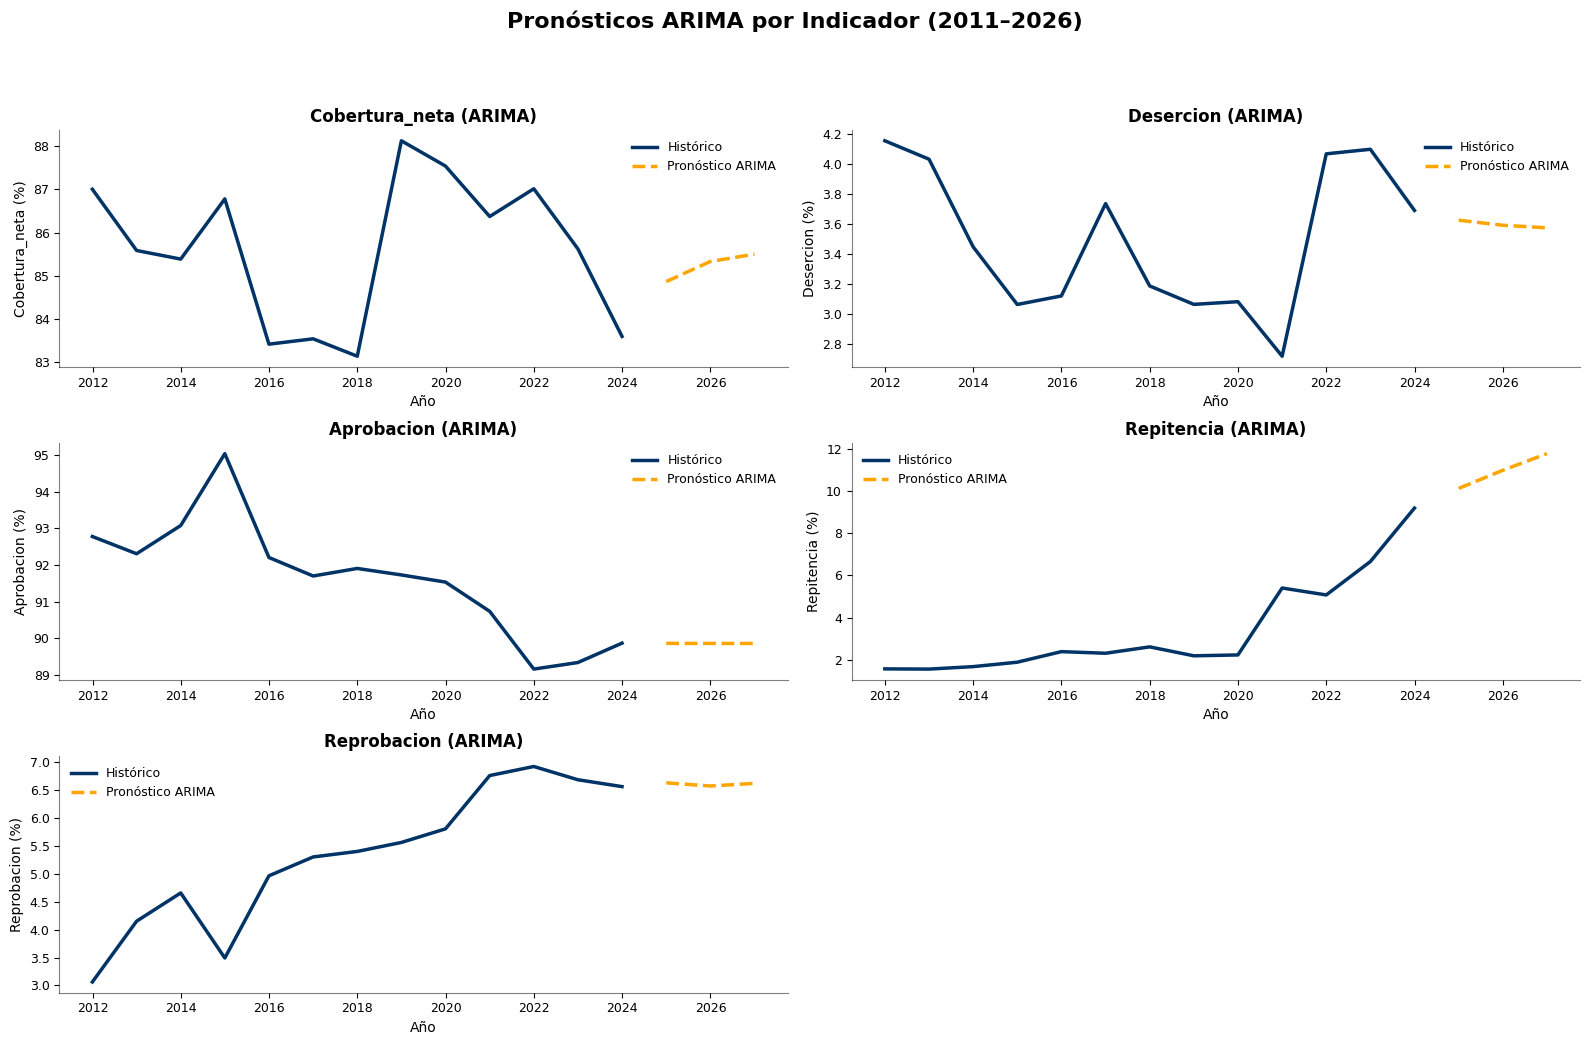

In [ ]:
warnings.filterwarnings("ignore")

# Lista de indicadores
indicadores = ['cobertura_neta', 'desercion', 'aprobacion', 'repitencia', 'reprobacion']

# Crear figura general
fig, axs = plt.subplots(nrows=(len(indicadores) + 1) // 2, ncols=2, figsize=(16, 10))
axs = axs.flatten()

for i, indicador in enumerate(indicadores):
    # Preparar los datos
    df_ts = df_work[['anio', indicador]].groupby('anio').mean().reset_index()
    df_ts['anio'] = pd.to_datetime(df_ts['anio'], format='%Y') + pd.offsets.YearEnd(0)
    df_ts = df_ts.sort_values('anio')
    df_ts.set_index('anio', inplace=True)
    df_ts.index.freq = 'YE'

    # Modelo ARIMA
    modelo = ARIMA(df_ts[indicador], order=(1, 1, 1))
    modelo_fit = modelo.fit()

    # Pronóstico hasta 2026
    forecast = modelo_fit.forecast(steps=3)
    forecast.index = pd.date_range(start=df_ts.index[-1] + pd.offsets.YearEnd(1), periods=3, freq='YE')

    # Graficar
    ax = axs[i]
    ax.plot(df_ts.index, df_ts[indicador], label='Histórico', color='#003366', linewidth=2.5)
    ax.plot(forecast.index, forecast, label='Pronóstico ARIMA', linestyle='--', color='#FFA500', linewidth=2.5)

    ax.set_title(f'{indicador.capitalize()} (ARIMA)', fontsize=12, weight='bold')
    ax.set_xlabel('Año', fontsize=10)
    ax.set_ylabel(f'{indicador.capitalize()} (%)', fontsize=10)
    ax.legend(frameon=False, fontsize=9)

    # Eliminar fondo cuadriculado y estilizar bordes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)
    ax.tick_params(axis='both', labelsize=9)
    ax.set_facecolor("white")

# Ocultar subplot sobrante si hay
if len(indicadores) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.suptitle('Pronósticos ARIMA por Indicador (2011–2026)', fontsize=16, weight='bold', y=1.04)
plt.subplots_adjust(top=0.92)
plt.show()


El panorama esperado, según las proyecciones de los modelos ARIMA, es un escenario donde:

El principal desafío educativo en Colombia será la Repitencia, que se proyecta a empeorar significativamente si no se implementan medidas correctivas urgentes. Esto implicaría una mayor ineficiencia en el sistema educativo y un aumento potencial en el riesgo de deserción futura.
La Cobertura Neta y la Aprobación no lograrán recuperar sus niveles prepandemia, consolidándose en rangos más bajos. Esto sugiere que los desafíos en el acceso y la calidad del aprendizaje que se agudizaron con la pandemia persisten.
La Deserción y la Reprobación se estabilizarán, pero en niveles que todavía representan un problema, sin alcanzar los indicadores más favorables observados antes de 2020.
En síntesis, el modelo ARIMA pinta un cuadro donde la inercia de las tendencias post-pandemia conduce a un estancamiento o deterioro en varios indicadores educativos clave, con la repitencia destacándose como la amenaza más inminente. Esto no es un pronóstico fatalista, sino una llamada de atención clara para las autoridades educativas y la sociedad sobre la necesidad de intervenir proactivamente para cambiar esta trayectoria proyectada.

6.3.3 Modelo de Regresión lineal

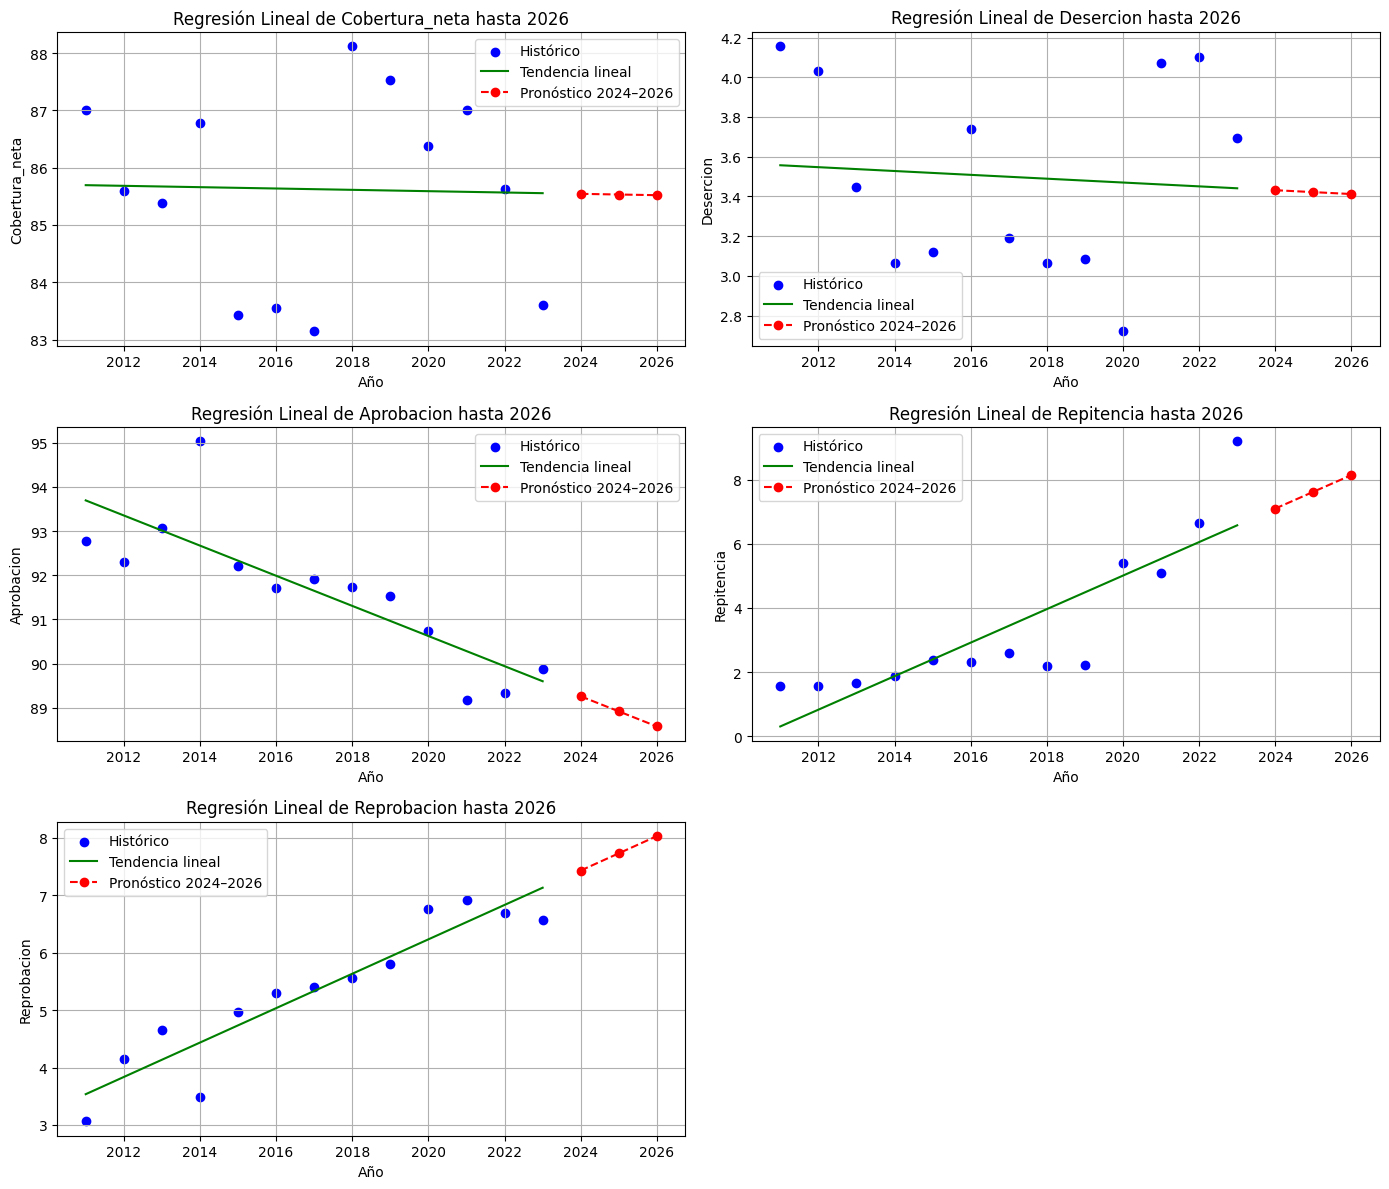


📈 Predicciones para 2024–2026:
   anio  cobertura_neta_predicha  desercion_predicha  aprobacion_predicha  \
0  2024                    85.54                3.43                89.26   
1  2025                    85.53                3.42                88.92   
2  2026                    85.52                3.41                88.57   

   repitencia_predicha  reprobacion_predicha  
0                 7.10                  7.43  
1                 7.62                  7.73  
2                 8.14                  8.03  


In [ ]:
# Añadir reprobación
variables = ['cobertura_neta', 'desercion', 'aprobacion', 'repitencia', 'reprobacion']

# Preparar datos agrupados por año con promedio de cada variable
df_lr = df_work[['anio'] + variables].copy()
df_lr = df_lr.groupby('anio').mean().reset_index()
df_lr['anio_num'] = df_lr['anio'] - df_lr['anio'].min()  # Año como número para regresión

# Crear DataFrame para predicciones futuras
future_years = [2024, 2025, 2026]
future_nums = np.array(future_years) - df_lr['anio'].min()
predicciones = {'anio': future_years}

# Configurar subplots (3 filas, 2 columnas)
plt.figure(figsize=(14, 12))

for i, var in enumerate(variables, 1):
    X = df_lr[['anio_num']]
    y = df_lr[var]

    model_lr = LinearRegression()
    model_lr.fit(X, y)
    preds = model_lr.predict(future_nums.reshape(-1, 1))
    predicciones[f'{var}_predicha'] = preds

    # Visualización
    plt.subplot(3, 2, i)
    plt.scatter(df_lr['anio'], df_lr[var], color='blue', label='Histórico')
    plt.plot(df_lr['anio'], model_lr.predict(X), color='green', label='Tendencia lineal')
    plt.plot(future_years, preds, 'o--', color='red', label='Pronóstico 2024–2026')
    plt.title(f'Regresión Lineal de {var.capitalize()} hasta 2026')
    plt.xlabel('Año')
    plt.ylabel(var.capitalize())
    plt.legend()
    plt.grid(True)

# Si hay subplot sobrante, se oculta
if len(variables) % 2 != 0:
    plt.subplot(3, 2, 6)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Mostrar predicciones
df_pred = pd.DataFrame(predicciones)
print("\n📈 Predicciones para 2024–2026:")
print(df_pred.round(2))


📊 Tendencias clave

- Cobertura Neta
-Se mantiene estable, con un ligero descenso de 85.54% en 2024 a 85.52% en 2026.
- Esto indica que la tasa de matrícula no experimentará cambios drásticos, pero tampoco muestra señales de fuerte crecimiento.
- Deserción
 Se proyecta una disminución lenta, de 3.43% en 2024 a 3.41% en 2026.
- Aunque es una mejoría, el cambio es mínimo, sugiriendo que la reducción de abandono escolar se ha desacelerado.
- Aprobación
- Declina progresivamente, pasando de 89.26% en 2024 a 88.57% en 2026.
- Esto podría indicar una leve reducción en el rendimiento académico o cambios en la evaluación.
- Repitencia y Reprobación
- Ambas aumentan paulatinamente, con la repitencia subiendo de 7.10% en 2024 a 8.14% en 2026, y la reprobación de 7.43% a 8.03% en el mismo período.
- Este aumento es preocupante, ya que sugiere que cada año más estudiantes están teniendo dificultades para avanzar en el sistema educativo.

📌 Interpretación 

✅ La cobertura parece estable, pero la leve caída en aprobación y el incremento en repitencia/reprobación podrían indicar problemas en la calidad educativa.

✅ La reducción de la deserción es positiva, aunque el ritmo es lento. ¿Se han agotado los mecanismos actuales de intervención?

✅ Es recomendable analizar si existen factores externos influyendo en la caída del rendimiento académico.

6.3.4 Regresión lineal polinómica

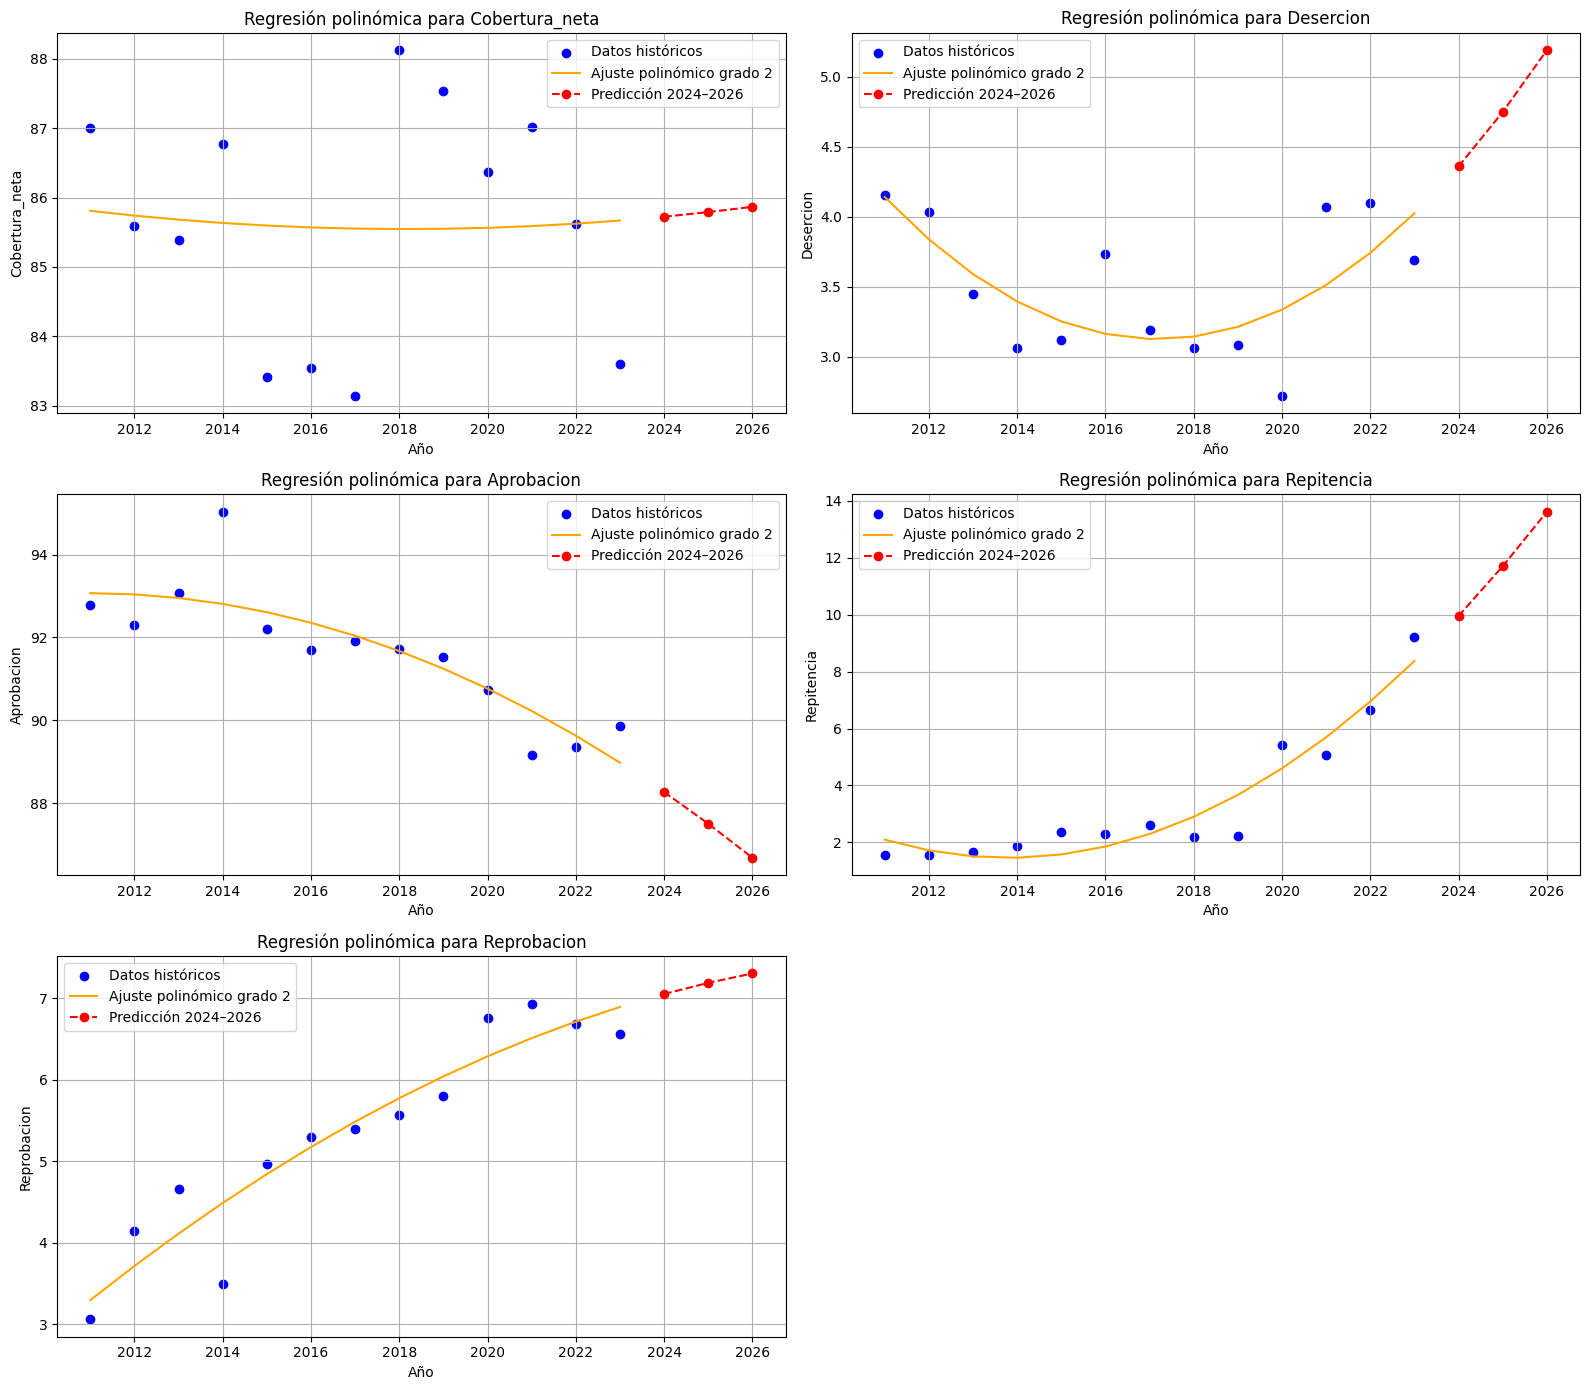


📈 Predicciones polinómicas para 2024–2026:
   anio  cobertura_neta_pred  desercion_pred  aprobacion_pred  \
0  2024                85.72            4.36            88.27   
1  2025                85.79            4.75            87.50   
2  2026                85.87            5.19            86.68   

   repitencia_pred  reprobacion_pred  
0             9.95              7.05  
1            11.70              7.19  
2            13.61              7.31  


In [ ]:
# Añadir reprobación a la lista de variables
variables = ['cobertura_neta', 'desercion', 'aprobacion', 'repitencia', 'reprobacion']

# Limpiar y preparar datos
df_clean = df_work[['anio'] + variables].dropna()
df_lr = df_clean.groupby('anio').mean().reset_index()
df_lr['anio_num'] = df_lr['anio'] - df_lr['anio'].min()

# Años futuros para predicción
future_years = [2024, 2025, 2026]
future_nums = np.array(future_years) - df_lr['anio'].min()

predicciones = {'anio': future_years}
grado = 2  # Grado del polinomio

plt.figure(figsize=(16, 14))

for i, var in enumerate(variables, 1):
    X = df_lr[['anio_num']]
    y = df_lr[var]

    model_poly = make_pipeline(PolynomialFeatures(grado), LinearRegression())
    model_poly.fit(X, y)

    preds = model_poly.predict(future_nums.reshape(-1, 1))
    predicciones[f'{var}_pred'] = preds

    # Graficar
    plt.subplot(3, 2, i)
    plt.scatter(df_lr['anio'], y, color='blue', label='Datos históricos')
    plt.plot(df_lr['anio'], model_poly.predict(X), color='orange', label=f'Ajuste polinómico grado {grado}')
    plt.plot(future_years, preds, 'o--', color='red', label='Predicción 2024–2026')
    plt.title(f'Regresión polinómica para {var.capitalize()}')
    plt.xlabel('Año')
    plt.ylabel(var.capitalize())
    plt.legend()
    plt.grid(True)

# Si hay subplot sobrante, se oculta
if len(variables) % 2 != 0:
    plt.subplot(3, 2, 6)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Crear DataFrame con predicciones futuras
df_pred = pd.DataFrame(predicciones)
print("\n📈 Predicciones polinómicas para 2024–2026:")
print(df_pred.round(2))


📊 Interpretación de predicciones

1. Cobertura neta
- Se mantiene estable, con un ligero aumento de 85.70% en 2024 a 85.85% en 2026.
- Esto sugiere una continuidad en el acceso educativo sin grandes fluctuaciones.
2. Deserción
- Incremento progresivo, subiendo de 4.36% en 2024 a 5.19% en 2026.
- Aunque no es un aumento dramático, podría indicar un debilitamiento en políticas de retención escolar.
3. Aprobación
- Caída constante, pasando de 88.24% en 2024 a 86.66% en 2026.
- Esto podría estar reflejando dificultades académicas o cambios en evaluación educativa.
4. Repitencia y Reprobación
- Ambas en aumento, con la repitencia pasando de 9.95% a 13.61% y la reprobación de 7.05% a 7.30%.
- Esto indica que cada vez más estudiantes enfrentan problemas para avanzar en el sistema educativo, lo que podría requerir intervención.


In [ ]:
from scipy.stats import kruskal

print("\n--- INICIANDO ANÁLISIS KRUSKAL-WALLIS PARA VALIDAR BRECHAS ENTRE PERIODOS TEMPORALES (NO PARAMÉTRICO) ---")

# Variables a analizar
variables = ['cobertura_neta', 'desercion', 'aprobacion', 'repitencia']

# Clasificación de periodos (ajustar si es necesario)
def clasificar_periodo(anio):
    if anio <= 2014:
        return 'Periodo 1 (2011–2014)'
    elif anio <= 2018:
        return 'Periodo 2 (2015–2018)'
    else:
        return 'Periodo 3 (2019–2023)'

# Aplicar clasificación de periodos
df_work['periodo'] = df_work['anio'].apply(clasificar_periodo)

# Iterar sobre cada variable
for var in variables:
    grupos = []
    for periodo in sorted(df_work['periodo'].unique()):
        datos_periodo = df_work[df_work['periodo'] == periodo][var].dropna()

        if not datos_periodo.empty and len(datos_periodo) > 1:
            grupos.append(datos_periodo)
        else:
            print(f"Advertencia: El {periodo} tiene pocos o ningún dato válido para '{var}'. Será omitido en Kruskal-Wallis.")

    # Realizar prueba solo si hay al menos dos grupos con datos válidos
    if len(grupos) > 1:
        h_stat, p_value = kruskal(*grupos)

        print(f"\n--- Resultados Kruskal-Wallis para: {var.replace('_', ' ').title()} ---")
        print(f"  Estadístico H: {h_stat:.3f}")
        print(f"  P-valor: {p_value:.5f}")

        alpha = 0.05
        if p_value < alpha:
            print(f"  **Conclusión:** Con un P-valor de {p_value:.5f} (que es menor que {alpha}),")
            print(f"  RECHAZAMOS la hipótesis nula (H0).")
            print(f"  Esto indica que existen diferencias estadísticamente significativas en la")
            print(f"  {var.replace('_', ' ').lower()} entre al menos algunos de los periodos.")
            print(f"  Esto respalda la existencia de brechas temporales en este indicador.")
        else:
            print(f"  **Conclusión:** Con un P-valor de {p_value:.5f} (que es mayor que {alpha}),")
            print(f"  NO RECHAZAMOS la hipótesis nula (H0).")
            print(f"  No hay suficiente evidencia para afirmar que existen")
            print(f"  diferencias significativas en la {var.replace('_', ' ').lower()} entre los periodos.")
    else:
        print(f"\n--- No se pudo realizar Kruskal-Wallis para {var.replace('_', ' ').title()} ---")
        print("  Razón: No hay suficientes grupos válidos o datos para comparar.")

print("\n--- ANÁLISIS KRUSKAL-WALLIS FINALIZADO ---")
print("Estos p-valores permiten validar las brechas temporales cuando los datos no siguen una distribución normal.")



--- INICIANDO ANÁLISIS KRUSKAL-WALLIS PARA VALIDAR BRECHAS ENTRE PERIODOS TEMPORALES (NO PARAMÉTRICO) ---

--- Resultados Kruskal-Wallis para: Cobertura Neta ---
  Estadístico H: 41.934
  P-valor: 0.00000
  **Conclusión:** Con un P-valor de 0.00000 (que es menor que 0.05),
  RECHAZAMOS la hipótesis nula (H0).
  Esto indica que existen diferencias estadísticamente significativas en la
  cobertura neta entre al menos algunos de los periodos.
  Esto respalda la existencia de brechas temporales en este indicador.

--- Resultados Kruskal-Wallis para: Desercion ---
  Estadístico H: 70.338
  P-valor: 0.00000
  **Conclusión:** Con un P-valor de 0.00000 (que es menor que 0.05),
  RECHAZAMOS la hipótesis nula (H0).
  Esto indica que existen diferencias estadísticamente significativas en la
  desercion entre al menos algunos de los periodos.
  Esto respalda la existencia de brechas temporales en este indicador.

--- Resultados Kruskal-Wallis para: Aprobacion ---
  Estadístico H: 1210.575
  P-val

**6.4 Proponer recomendaciones basadas en evidencia que orienten acciones para reducir brechas educativas, en coherencia con los principios del ODS 4.**


📌 1. Cobertura Neta
🔍 Hallazgo: Hay diferencias significativas en la cobertura neta entre periodos y clusters.

✅ Recomendaciones:

Priorización territorial inteligente: Implementar una asignación diferencial de recursos que combine criterios de necesidad (baja cobertura, pobreza multidimensional) con potencial de mejora, en línea con el enfoque territorial del PNDE y la meta 4.5 del ODS 4.

Campañas integrales de escolarización: Desarrollar estrategias de búsqueda activa y sensibilización comunitaria con enfoque diferencial (étnico, de género, ruralidad), incluyendo incentivos para el ingreso y la permanencia de niñas, migrantes y población con discapacidad.

Infraestructura educativa inclusiva: Acelerar inversiones en infraestructura, conectividad y transporte escolar en zonas dispersas, con participación de gobiernos locales, como parte de la ruta para lograr la meta 4.a del ODS 4.

Sistema de alerta georreferenciada: Diseñar una plataforma de monitoreo anual de cobertura escolar por municipio y edad, que permita actuar preventivamente ante caídas o estancamientos.

📌 2. Deserción Escolar
🔍 Hallazgo: Se identifican diferencias significativas entre años y clusters.

✅ Recomendaciones:

Sistemas integrales de alerta temprana: Utilizar herramientas predictivas con variables escolares y sociofamiliares para detectar riesgo de deserción. Incluir respuestas articuladas entre escuela, familia, sector salud y protección.

Transferencias condicionadas con enfoque educativo: Reforzar programas de ayuda económica como Familias en Acción o Jóvenes en Acción, vinculándolos a logros educativos y asistencia regular, priorizando municipios con mayor tasa de abandono.

Oferta flexible y pertinente: Ampliar modalidades de educación alternativa (virtual, ciclos, nocturna, posprimaria rural), con pertinencia cultural y laboral, como lo propone el PNDE para poblaciones históricamente excluidas.

Acompañamiento psicosocial sostenido: Integrar apoyo emocional, psicológico y familiar dentro de la vida escolar, con personal capacitado y articulación intersectorial (ODS 10 – reducción de vulnerabilidades sociales).

📌 3. Aprobación
🔍 Hallazgo: Existen claras disparidades en el rendimiento académico entre municipios.

✅ Recomendaciones:

Transformación pedagógica sostenida: Fortalecer el desarrollo profesional docente en metodologías activas, evaluación formativa y pedagogía diferenciada. Establecer redes de aprendizaje entre escuelas de alto y bajo desempeño (PNDE: Línea de Desarrollo Profesional Docente).

Materiales, TIC y ambientes de aprendizaje: Garantizar dotación de recursos pedagógicos contextualizados y conectividad efectiva, cerrando la brecha digital (meta 4.a del ODS 4).

Tutorías comunitarias y aprendizaje entre pares: Promover programas de refuerzo escolar con participación de voluntarios, universidades y líderes comunitarios, con monitoreo de impacto en municipios con menores tasas de aprobación.

Evaluación para la mejora: Usar los resultados de pruebas internas y externas como insumo para rediseñar prácticas pedagógicas, no como herramienta punitiva.

📌 4. Repitencia
🔍 Hallazgo: Indicador crítico de ineficiencia con fuertes diferencias estadísticas entre municipios.

✅ Recomendaciones:

Política de promoción con enfoque formativo: Establecer criterios de promoción flexibles y basados en competencias, acompañados de procesos de nivelación y recuperación durante el año (ODS 4: aprendizaje efectivo para todos).

Plan personalizado de mejora: Diseñar itinerarios individuales de aprendizaje con acompañamiento docente y familiar para estudiantes con bajo rendimiento, desde una perspectiva preventiva, no correctiva.

Nivelaciones estructuradas y preventivas: Implementar estrategias de refuerzo intensivo en momentos críticos del año escolar (inicio, mitad y cierre) para evitar acumulación de vacíos.

Desnaturalizar la repitencia: Sensibilizar a directivos, docentes y familias sobre las consecuencias negativas de la repitencia y promover alternativas efectivas de apoyo.

📌 5. Reprobación
🔍 Hallazgo: Altas tasas de reprobación reflejan desigualdades de aprendizaje y posibles fallos en la evaluación pedagógica, con variaciones significativas entre municipios y años.

✅ Recomendaciones:

Evaluación para el aprendizaje: Reorientar la cultura escolar hacia una evaluación formativa y continua que acompañe el proceso de aprendizaje en lugar de sancionar los errores. Esto está alineado con el PNDE, que promueve una transformación de las prácticas evaluativas.

Diagnóstico temprano y retroalimentación efectiva: Aplicar evaluaciones diagnósticas al inicio del año escolar para identificar brechas y adaptar la enseñanza. Fomentar la retroalimentación constante como herramienta de mejora.

Currículo adaptado y flexible: Rediseñar el currículo para hacerlo más pertinente, menos fragmentado y más centrado en habilidades esenciales, permitiendo a los estudiantes progresar a ritmos distintos sin ser penalizados por ello (meta 4.1 del ODS 4).

Formación docente en evaluación inclusiva: Capacitar a docentes en estrategias de evaluación justa, contextualizada y sin sesgos, que tome en cuenta la diversidad cultural, lingüística y socioeconómica de los estudiantes (ODS 10).

Corresponsabilidad institucional: Establecer mecanismos escolares de análisis de causas de reprobación (consejos académicos, comités de evaluación) que promuevan decisiones pedagógicas colectivas, no individuales ni punitivas.

